In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

from ast import literal_eval

import re
import string
import pprint

In [2]:
import spacy

from collections import Counter
from string import punctuation

In [4]:
import gensim
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim import corpora, similarities
from gensim.models import TfidfModel, LsiModel, LdaModel, RpModel, HdpModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

In [6]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

## 1) Read in the data

In [7]:
movies = pd.read_csv('final_dataset.csv', lineterminator='\n', index_col=0)
print(movies.shape)
movies.head()

(47723, 8)


,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"['tom_hanks', 'tim_allen', 'don_rickles', 'jim..."
1,2,8844,113497,Jumanji,"['Adventure', 'Children', 'Fantasy']",When siblings Judy and Peter discover an encha...,joe_johnston,"['robin_williams', 'kirsten_dunst', 'bradley_p..."
2,3,15602,113228,Grumpier Old Men,"['Comedy', 'Romance']",A family wedding reignites the ancient feud be...,howard_deutch,"['walter_matthau', 'jack_lemmon', 'ann-margret..."
3,4,31357,114885,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"['whitney_houston', 'angela_bassett', 'loretta..."
4,5,11862,113041,Father of the Bride Part II,['Comedy'],Just when George Banks has recovered from his ...,charles_shyer,"['steve_martin', 'diane_keaton', 'martin_short..."


#### Lists in columns got turned into text strings during save to csv; need to undo that

In [8]:
movies['genres'] = movies['genres'].map(literal_eval)
movies['actors'] = movies['actors'].map(literal_eval)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]"
1,2,8844,113497,Jumanji,"[Adventure, Children, Fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce..."
2,3,15602,113228,Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop..."
3,4,31357,114885,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi..."
4,5,11862,113041,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim..."


## 2) Tokenize the 'overview' column

#### (Use of SpaCy based on: https://betterprogramming.pub/extract-keywords-using-spacy-in-python-4a8415478fbf)

In [9]:
nlp = spacy.load('en_core_web_lg')

In [10]:
# Remove '-' & '_' from punctuation list since these can appear in some overview text (e.g., 'C3-PO', 'R2-D2', etc.)

punctuation = punctuation.replace('-','').replace('_','')

In [11]:
def get_cleaned(text):
    result = []
    doc = nlp(text.lower())
    for token in doc:
        if(token.text in STOPWORDS or token.text in punctuation):
            continue
        # Discard any word less than 3 characters long
        elif len(token.text) > 2:
            result.append(token.text)
                
    return list(set(result))

In [12]:
movies['plot_tokens'] = movies['overview'].map(get_cleaned)

#### (Bigram/Trigrams based on: https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents)

In [15]:
# Add in bi-grams and tri-grams appearing at least twice

bigram = Phrases(movies['plot_tokens'], min_count=2)
trigram = Phrases(bigram[movies['plot_tokens']], min_count=2)

for idx in range(len(movies['plot_tokens'])):
    for token in trigram[movies['plot_tokens'][idx]]:
        if '_' in token:
            # Token is a bigram or trigram, add to document
            movies['plot_tokens'][idx].append(token)

In [19]:
movies['genres'] = movies['genres'].map(lambda x: [el.lower() for el in x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]","[live, andy, woody, owner, brings, learns, asi..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...","[alan, monkeys, creatures, enchanted, freedom,..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...","[time, interested, john, seafood, local, sultr..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...","[elusive, bernie, waiting, stepped, cheated, t..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...","[home, expecting, change, receives, planning, ..."


In [20]:
movies['director'] = movies['director'].map(lambda x: [x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[live, andy, woody, owner, brings, learns, asi..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[alan, monkeys, creatures, enchanted, freedom,..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[time, interested, john, seafood, local, sultr..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[elusive, bernie, waiting, stepped, cheated, t..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[home, expecting, change, receives, planning, ..."


#### Combine all tokens into one 'corpus' column

In [21]:
cols = ['genres', 'director', 'actors', 'plot_tokens']

movies['corpus'] = ''

for n, row in movies.iterrows():
    val = ''
    for col in cols:
        val += ' '.join(row[col])
        val += ' '
    movies.at[n,'corpus'] = val

In [22]:
movies['corpus'] = movies['corpus'].map(lambda x: x.split())
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[live, andy, woody, owner, brings, learns, asi...","[adventure, animation, children, comedy, fanta..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[alan, monkeys, creatures, enchanted, freedom,...","[adventure, children, fantasy, joe_johnston, r..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[time, interested, john, seafood, local, sultr...","[comedy, romance, howard_deutch, walter_mattha..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[elusive, bernie, waiting, stepped, cheated, t...","[comedy, drama, romance, forest_whitaker, whit..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[home, expecting, change, receives, planning, ...","[comedy, charles_shyer, steve_martin, diane_ke..."


#### Convert from corpus to Gensim Dictionary

In [41]:
dictionary = corpora.Dictionary(list(movies['corpus']))
print('With no dictionary filtering, there are this many unique tokens: ')
print(dictionary)

Prior to filtering, there are this many unique tokens: 
Dictionary(176709 unique tokens: ['adventure', 'afraid', 'andy', 'animation', 'aside']...)


In [42]:
bag_of_words = [dictionary.doc2bow(text) for text in list(movies['corpus'])]
tfidf = TfidfModel(bag_of_words)
corpus_tfidf = tfidf[bag_of_words]

#### Use Coherence to determine how many topics to model (lower Coherence value is better)

In [43]:
def compute_coherences(corpus_tfidf, dictionary, num_topics_list):
    coherences = []
    for num in num_topics_list:
        print('Computing coherence for {} topics...'.format(num))
        coherences.append(CoherenceModel(model=LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num),
                                         corpus=corpus_tfidf,
                                         dictionary=dictionary,
                                         coherence='u_mass').get_coherence()
                         )
        print('   Coherence: {}'.format(coherences[-1]))
    return coherences

In [171]:
num_topics_list = [50, 100, 200, 500, 1000, 1500, 2000, 2250, 2500, 2750, 3000]
coherences = compute_coherences(corpus_tfidf, dictionary, num_topics_list)

Computing coherence for 50 topics...
   Coherence: -3.430820335869808
Computing coherence for 100 topics...
   Coherence: -3.5752280217652994
Computing coherence for 200 topics...
   Coherence: -3.8918636633567267
Computing coherence for 500 topics...
   Coherence: -4.911784781826408
Computing coherence for 1000 topics...
   Coherence: -7.063027083146943
Computing coherence for 1500 topics...
   Coherence: -9.193534522835304
Computing coherence for 2000 topics...
   Coherence: -10.899250342106807
Computing coherence for 2250 topics...
   Coherence: -11.603167227169765
Computing coherence for 2500 topics...
   Coherence: -12.19444400357292
Computing coherence for 2750 topics...
   Coherence: -12.746135316422851
Computing coherence for 3000 topics...
   Coherence: -13.177296567044381


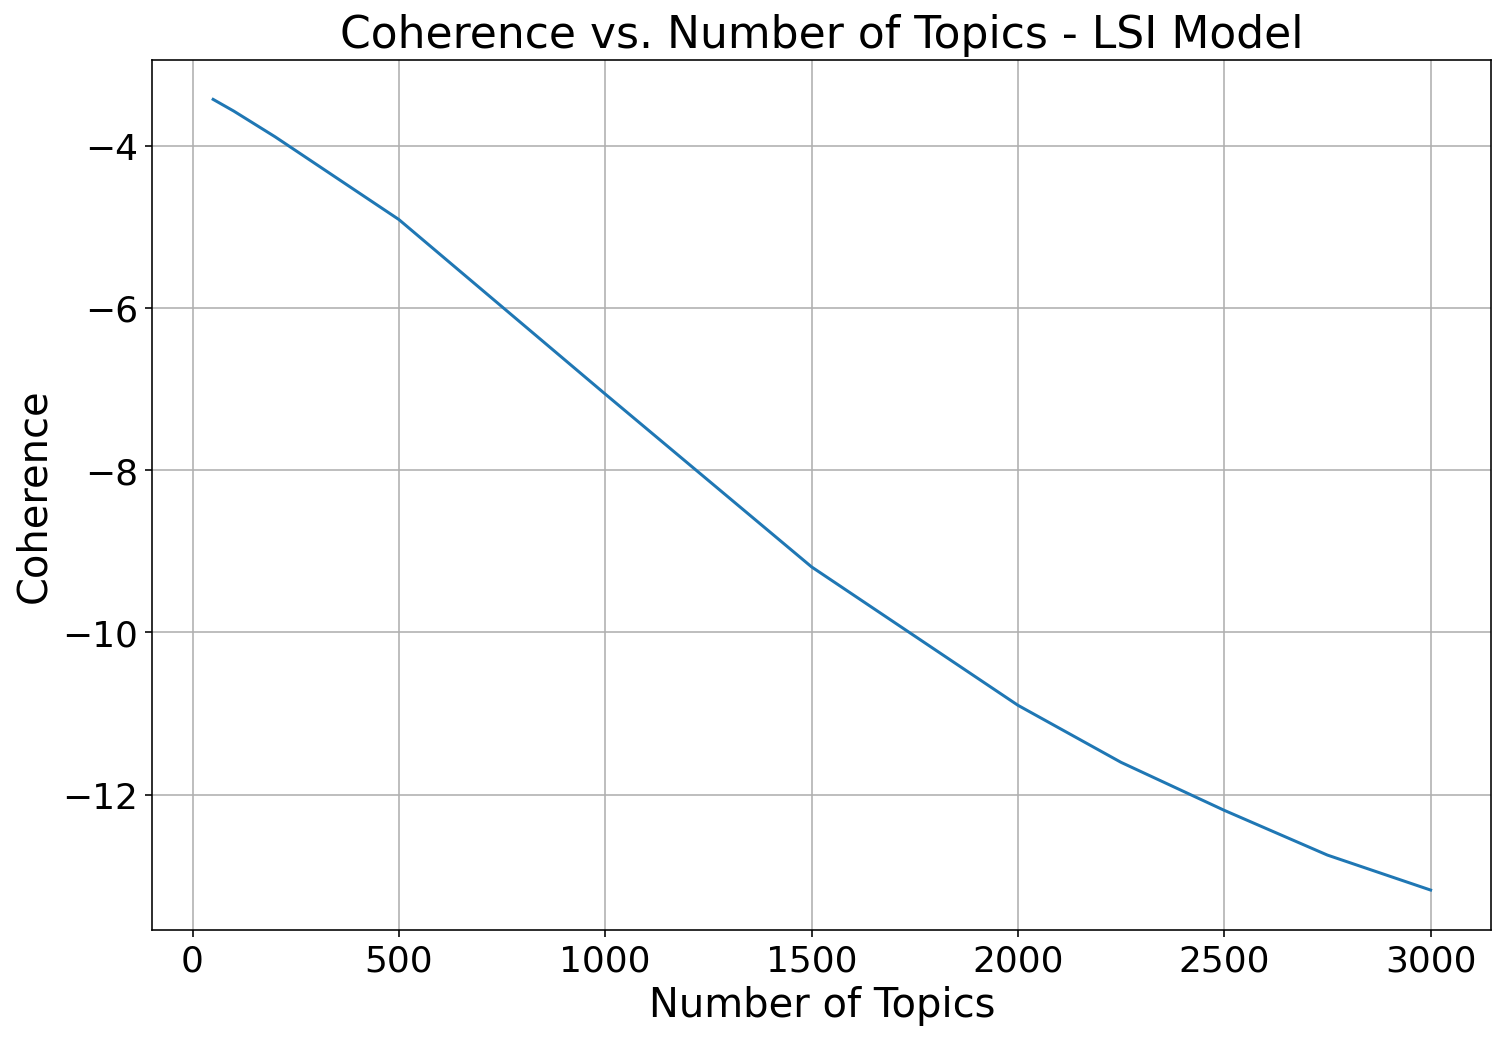

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(num_topics_list, coherences)
plt.title('Coherence vs. Number of Topics - LSI Model', size=22)
plt.xlabel('Number of Topics', size=20)
plt.ylabel('Coherence', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.grid();

In [45]:
## Use LSI to reduce dimensionality (just using tfidf causes an out-of-memory condition upon similarity lookkup)

lsi = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=3000)

In [46]:
for n in range(0, lsi.num_topics-1):
    print('Topic # {}: {}'.format(n, lsi.print_topic(n)))

Topic # 0: 0.160*"comedy" + 0.154*"drama" + 0.151*"thriller" + 0.148*"romance" + 0.135*"crime" + 0.134*"action" + 0.132*"young" + 0.125*"life" + 0.118*"man" + 0.114*"horror"
Topic # 1: 0.333*"thriller" + 0.316*"crime" + 0.274*"action" + -0.251*"romance" + 0.200*"mystery" + 0.197*"horror" + -0.191*"love" + -0.158*"comedy" + 0.152*"sci-fi" + 0.116*"murder"
Topic # 2: 0.363*"war" + 0.278*"documentary" + 0.250*"adventure" + -0.242*"crime" + 0.182*"world" + -0.177*"mystery" + -0.159*"thriller" + 0.157*"sci-fi" + 0.152*"action" + -0.138*"woman"
Topic # 3: -0.332*"war" + 0.289*"horror" + -0.285*"crime" + -0.264*"documentary" + 0.245*"children" + 0.212*"fantasy" + 0.211*"sci-fi" + 0.179*"adventure" + 0.170*"animation" + -0.113*"drama"
Topic # 4: -0.576*"documentary" + 0.296*"war" + -0.223*"horror" + 0.181*"adventure" + 0.179*"action" + -0.179*"film" + 0.176*"romance" + -0.118*"mystery" + 0.103*"western" + 0.101*"love"
Topic # 5: -0.398*"war" + -0.331*"horror" + 0.281*"crime" + 0.183*"action" +

#### Compute cosine similarities

In [47]:
sim_index = similarities.SparseMatrixSimilarity(lsi[bag_of_words], num_terms=movies.shape[0])

In [59]:
# Save sim_index to file

sim_index.save('lsi_sim_index.pcl')

In [60]:
# Save LSI model to file

lsi.save("lsi.model")

In [61]:
# Save movies dataset w/ corpus to file

movies.to_csv('dataset_with_corpus.csv', index=True)

## 3) Generating Recommendations

#### (Can just continue from here and NOT run anything above, except the imports at the top, in the future)

#### Load in the saved files to generate recommendations:

In [62]:
sim_index = similarities.SparseMatrixSimilarity.load('lsi_sim_index.pcl')

In [63]:
model = LsiModel.load('lsi.model')

In [64]:
movies = pd.read_csv('dataset_with_corpus.csv', lineterminator='\n', index_col=0)
movies['genres'] = movies['genres'].map(literal_eval)
movies['director'] = movies['director'].map(literal_eval)
movies['actors'] = movies['actors'].map(literal_eval)
movies['plot_tokens'] = movies['plot_tokens'].map(literal_eval)
movies['corpus'] = movies['corpus'].map(literal_eval)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[live, andy, woody, owner, brings, learns, asi...","[adventure, animation, children, comedy, fanta..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[alan, monkeys, creatures, enchanted, freedom,...","[adventure, children, fantasy, joe_johnston, r..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[time, interested, john, seafood, local, sultr...","[comedy, romance, howard_deutch, walter_mattha..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[elusive, bernie, waiting, stepped, cheated, t...","[comedy, drama, romance, forest_whitaker, whit..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[home, expecting, change, receives, planning, ...","[comedy, charles_shyer, steve_martin, diane_ke..."


In [65]:
# Re-create the Gensim dictionary

dictionary = corpora.Dictionary(list(movies['corpus']))
print(dictionary)

Prior to filtering, there are this many unique tokens: 
Dictionary(176709 unique tokens: ['adventure', 'afraid', 'andy', 'animation', 'aside']...)


In [66]:
bag_of_words = [dictionary.doc2bow(text) for text in list(movies['corpus'])]
tfidf = TfidfModel(bag_of_words)
corpus_tfidf = tfidf[bag_of_words]

In [67]:
def recommend(movie_id, len=20):
    movie_idx = movies[movies['movieId'] == movie_id].index[0]
    rec_indices = sim_index[model[dictionary.doc2bow(movies['corpus'][movie_idx])]].argsort()[::-1][0:len+1]
    rec_indices = [rec_idx for rec_idx in rec_indices if rec_idx != movie_idx]
    print('Recommendations based on your interest in {}:'
               .format(movies[movies['movieId'] == movie_id]['title'].values[0]))
    recommendations = movies.iloc[rec_indices, np.r_[3:5, 6:8]]
    recommendations['relevancy'] = sim_index[model[dictionary.doc2bow(movies['corpus'][movie_idx])]][rec_indices]
    return recommendations

In [50]:
## Final Gensim Model: LSI w/ bi-grams, tri-grams, no dictionary filtering (176,709 unique terms) & 3000 topics

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.531714
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.452569
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.394082
14800,Toy Story 3,"[adventure, animation, children, comedy, fanta...",[lee_unkrich],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.380493
46992,Buzz Lightyear of Star Command: The Adventure ...,"[adventure, animation, children, comedy, sci-fi]",[tad_stones],"[tim_allen, nicole_sullivan, stephen_furst, la...",0.356884
26417,Halloweentown,"[adventure, children, comedy, fantasy]",[duwayne_dunham],"[debbie_reynolds, kimberly_j._brown, judith_ho...",0.318309
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.310298
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",0.310231
28159,The Pasta Detectives,"[adventure, children, comedy]",[neele_vollmar],"[anton_petzold, juri_winkler, karoline_herfurt...",0.306801
17551,Mr. Bug Goes to Town,"[animation, children, comedy, fantasy, musical]",[dave_fleischer],"[kenny_gardner, gwen_williams, jack_mercer, te...",0.304358


In [132]:
## This is what LSI w/ bi-grams, tri-grams, 100/0.005 filtering & 1360 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
35981,Ordinary World,"[comedy, drama]",[lee_kirk],"[billie_joe_armstrong, fred_armisen, judy_gree...",0.436329
11041,Little Children,"[drama, romance]",[todd_field],"[kate_winslet, patrick_wilson, jennifer_connel...",0.378231
21954,Bright Lights,[comedy],[busby_berkeley],"[joe_e._brown, ann_dvorak, patricia_ellis, wil...",0.378231
13735,Angel,"[comedy, drama, romance]",[ernst_lubitsch],"[marlene_dietrich, herbert_marshall, melvyn_do...",0.378231
29086,The Dolls,"[comedy, romance]",[dino_risi],"[virna_lisi, nino_manfredi, alicia_brandet, mo...",0.378231
35929,A Boyfriend for My Wife,"[comedy, drama, romance]",[juan_taratuto],"[adrián_suar, valeria_bertuccelli, gabriel_goi...",0.378231
27479,Five Days,"[crime, thriller]",[montgomery_tully],"[dane_clark, cecile_chevreau, paul_carpenter, ...",0.378097
17011,Restless,[drama],[gus_van_sant],"[mia_wasikowska, henry_hopper, ryō_kase, schuy...",0.378097
41562,Bluebeard,"[drama, fantasy, horror]",[georges_méliès],"[georges_méliès, jehanne_d'alcy, bleuette_bern...",0.378097
6750,The Navigator,[comedy],[buster_keaton],"[buster_keaton, kathryn_mcguire, frederick_vro...",0.378097


In [79]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.002 filtering & 3000 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
14800,Toy Story 3,"[adventure, animation, children, comedy, fanta...",[lee_unkrich],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.750589
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.640071
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.578188
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.565848
46992,Buzz Lightyear of Star Command: The Adventure ...,"[adventure, animation, children, comedy, sci-fi]",[tad_stones],"[tim_allen, nicole_sullivan, stephen_furst, la...",0.517462
20682,Toy Story of Terror!,"[animation, children, comedy]",[angus_maclane],"[joan_cusack, carl_weathers, tom_hanks, tim_al...",0.510169
46095,An Unusual Match,[animation],[mstislav_pashchenko],"[margarita_korabelnikova, yuliya_yulskaya, yur...",0.499737
24407,Partysaurus Rex,"[animation, children, comedy]",[mark_a._walsh],"[wallace_shawn, tom_hanks, tim_allen, corey_bu...",0.489547
24408,Toy Story That Time Forgot,"[animation, children]",[steve_purcell],"[kristen_schaal, kevin_mckidd, tom_hanks, tim_...",0.472137
45152,California Typewriter,[documentary],[doug_nichol],"[tom_hanks, john_mayer, silvi_alcivar, ken_ale...",0.464385


In [59]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.001 filtering & 2000 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
14800,Toy Story 3,"[adventure, animation, children, comedy, fanta...",[lee_unkrich],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.807402
46992,Buzz Lightyear of Star Command: The Adventure ...,"[adventure, animation, children, comedy, sci-fi]",[tad_stones],"[tim_allen, nicole_sullivan, stephen_furst, la...",0.797653
42638,Fired!,"[comedy, documentary]",[kyle_labrache],"[stephen_adly_guirgis, w._bruce_cameron, tim_a...",0.652113
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.639088
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.626686
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.588050
15551,Crazy on the Outside,"[comedy, crime]",[tim_allen],"[tim_allen, sigourney_weaver, ray_liotta, j.k....",0.579090
10562,The Shaggy Dog,"[adventure, children, comedy, fantasy]",[brian_robbins],"[tim_allen, kristin_davis, danny_glover, spenc...",0.516097
20682,Toy Story of Terror!,"[animation, children, comedy]",[angus_maclane],"[joan_cusack, carl_weathers, tom_hanks, tim_al...",0.494856
5527,The Santa Clause 2,"[children, comedy, fantasy, romance]",[michael_lembeck],"[tim_allen, elizabeth_mitchell, david_krumholt...",0.483917


In [41]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.005 filtering & 3000 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.514106
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.414233
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.375078
14800,Toy Story 3,"[adventure, animation, children, comedy, fanta...",[lee_unkrich],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.355644
26417,Halloweentown,"[adventure, children, comedy, fantasy]",[duwayne_dunham],"[debbie_reynolds, kimberly_j._brown, judith_ho...",0.333918
46992,Buzz Lightyear of Star Command: The Adventure ...,"[adventure, animation, children, comedy, sci-fi]",[tad_stones],"[tim_allen, nicole_sullivan, stephen_furst, la...",0.323899
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.317848
10642,The Wild,"[adventure, animation, children, comedy, fantasy]",[steve_'spaz'_williams],"[kiefer_sutherland, jim_belushi, eddie_izzard,...",0.313202
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",0.309944
28159,The Pasta Detectives,"[adventure, children, comedy]",[neele_vollmar],"[anton_petzold, juri_winkler, karoline_herfurt...",0.307093


In [46]:
## This is what LSI w/ Spacy Keyword Extraction & 3000 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.551373
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.477844
14800,Toy Story 3,"[adventure, animation, children, comedy, fanta...",[lee_unkrich],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.423840
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.412078
46992,Buzz Lightyear of Star Command: The Adventure ...,"[adventure, animation, children, comedy, sci-fi]",[tad_stones],"[tim_allen, nicole_sullivan, stephen_furst, la...",0.371308
26417,Halloweentown,"[adventure, children, comedy, fantasy]",[duwayne_dunham],"[debbie_reynolds, kimberly_j._brown, judith_ho...",0.341825
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.322054
14959,The Wizard of Oz,"[adventure, children, comedy, fantasy]",[larry_semon],"[dorothy_dwan, mary_carr, charles_murray, oliv...",0.321175
28159,The Pasta Detectives,"[adventure, children, comedy]",[neele_vollmar],"[anton_petzold, juri_winkler, karoline_herfurt...",0.316392
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",0.314532


In [27]:
## This is what LSI w/ 3000 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.540007
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.455541
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.441024
24407,Partysaurus Rex,"[animation, children, comedy]",[mark_a._walsh],"[wallace_shawn, tom_hanks, tim_allen, corey_bu...",0.376469
14800,Toy Story 3,"[adventure, animation, children, comedy, fanta...",[lee_unkrich],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.375866
46992,Buzz Lightyear of Star Command: The Adventure ...,"[adventure, animation, children, comedy, sci-fi]",[tad_stones],"[tim_allen, nicole_sullivan, stephen_furst, la...",0.339004
11812,Valhalla,"[adventure, animation, children, fantasy]",[peter_madsen],"[dick_kaysø, preben_kristensen, laura_bro, mar...",0.307971
17551,Mr. Bug Goes to Town,"[animation, children, comedy, fantasy, musical]",[dave_fleischer],"[kenny_gardner, gwen_williams, jack_mercer, te...",0.298597
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.295008
14959,The Wizard of Oz,"[adventure, children, comedy, fantasy]",[larry_semon],"[dorothy_dwan, mary_carr, charles_murray, oliv...",0.293317


In [68]:
## This is what LSI w/ 2000 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.557688
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.464216
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.455825
24407,Partysaurus Rex,"[animation, children, comedy]",[mark_a._walsh],"[wallace_shawn, tom_hanks, tim_allen, corey_bu...",0.377815
14800,Toy Story 3,"[adventure, animation, children, comedy, fanta...",[lee_unkrich],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.370581
46992,Buzz Lightyear of Star Command: The Adventure ...,"[adventure, animation, children, comedy, sci-fi]",[tad_stones],"[tim_allen, nicole_sullivan, stephen_furst, la...",0.347508
17551,Mr. Bug Goes to Town,"[animation, children, comedy, fantasy, musical]",[dave_fleischer],"[kenny_gardner, gwen_williams, jack_mercer, te...",0.342216
11812,Valhalla,"[adventure, animation, children, fantasy]",[peter_madsen],"[dick_kaysø, preben_kristensen, laura_bro, mar...",0.331122
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.328089
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",0.327531


In [58]:
## This is what LSI w/ 1000 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.571178
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.483719
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.452647
17551,Mr. Bug Goes to Town,"[animation, children, comedy, fantasy, musical]",[dave_fleischer],"[kenny_gardner, gwen_williams, jack_mercer, te...",0.412125
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.411712
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",0.404221
10841,The Ant Bully,"[adventure, animation, children, comedy, fanta...",[john_a._davis],"[julia_roberts, meryl_streep, nicolas_cage, pa...",0.397272
17410,Asterix and the Vikings,"[adventure, animation, children, comedy, fantasy]",[stefan_fjeldmark],"[roger_carel, lorànt_deutsch, sara_forestier, ...",0.391549
26417,Halloweentown,"[adventure, children, comedy, fantasy]",[duwayne_dunham],"[debbie_reynolds, kimberly_j._brown, judith_ho...",0.389691
11812,Valhalla,"[adventure, animation, children, fantasy]",[peter_madsen],"[dick_kaysø, preben_kristensen, laura_bro, mar...",0.387276


In [47]:
## This is what LSI w/ 500 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.611378
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.537522
10841,The Ant Bully,"[adventure, animation, children, comedy, fanta...",[john_a._davis],"[julia_roberts, meryl_streep, nicolas_cage, pa...",0.499942
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.484199
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.480680
17551,Mr. Bug Goes to Town,"[animation, children, comedy, fantasy, musical]",[dave_fleischer],"[kenny_gardner, gwen_williams, jack_mercer, te...",0.479684
17410,Asterix and the Vikings,"[adventure, animation, children, comedy, fantasy]",[stefan_fjeldmark],"[roger_carel, lorànt_deutsch, sara_forestier, ...",0.477144
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",0.474101
45363,Trolls Holiday,"[adventure, animation, children, comedy, fantasy]",[joel_crawford],"[anna_kendrick, justin_timberlake, zooey_desch...",0.455698
26417,Halloweentown,"[adventure, children, comedy, fantasy]",[duwayne_dunham],"[debbie_reynolds, kimberly_j._brown, judith_ho...",0.455527


In [36]:
## This is what LSI w/ 100 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.855566
17410,Asterix and the Vikings,"[adventure, animation, children, comedy, fantasy]",[stefan_fjeldmark],"[roger_carel, lorànt_deutsch, sara_forestier, ...",0.826972
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.811239
4637,"Monsters, Inc.","[adventure, animation, children, comedy, fantasy]",[pete_docter],"[john_goodman, billy_crystal, mary_gibbs, stev...",0.810727
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.790128
43497,Pokémon the Movie: I Choose You!,"[adventure, animation, children, comedy, drama...",[kunihiko_yuyama],"[rica_matsumoto, ikue_otani, megumi_hayashibar...",0.789500
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",0.785571
45363,Trolls Holiday,"[adventure, animation, children, comedy, fantasy]",[joel_crawford],"[anna_kendrick, justin_timberlake, zooey_desch...",0.783075
2173,A Bug's Life,"[adventure, animation, children, comedy]",[john_lasseter],"[dave_foley, kevin_spacey, julia_louis-dreyfus...",0.777157
4075,Shrek,"[adventure, animation, children, comedy, fanta...",[andrew_adamson],"[mike_myers, eddie_murphy, cameron_diaz, john_...",0.767540


In [34]:
movies[movies['title'] == 'Chinatown']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1161,1252,829,71315,Chinatown,"[crime, film-noir, mystery, thriller]",Private eye Jake Gittes lives off of the murky...,[roman_polanski],"[jack_nicholson, faye_dunaway, john_huston, pe...","[private, eye, jake, gittes, lives, off, of, t...",crime film-noir mystery thriller roman_polansk...


In [51]:
## Final Gensim Model: LSI w/ bi-grams, tri-grams, no dictionary filtering (176,709 unique terms) & 3000 topics

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
21045,The Big Fix,"[comedy, mystery, thriller]",[jeremy_kagan],"[richard_dreyfuss, susan_anspach, bonnie_bedel...",0.327913
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.304853
39562,City of Tiny Lights,"[crime, drama, thriller]",[pete_travis],"[riz_ahmed, cush_jumbo, james_floyd, billie_pi...",0.283971
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.277446
3513,Shaft,"[action, crime, drama, thriller]",[gordon_parks],"[richard_roundtree, moses_gunn, charles_cioffi...",0.273321
22913,Chandler,"[crime, drama]",[paul_magwood],"[warren_oates, leslie_caron, alex_dreier, mitc...",0.267954
18875,Cry Wolf,"[crime, drama, mystery, thriller]",[peter_godfrey],"[errol_flynn, barbara_stanwyck, geraldine_broo...",0.258858
34292,Hustle and Heat,"[action, comedy, crime, romance, thriller]",[craig_ross_jr.],"[duane_martin, vivica_a._fox, meagan_good, mic...",0.253916
22793,A Walk Among the Tombstones,"[action, crime, mystery, thriller]",[scott_frank],"[liam_neeson, dan_stevens, david_harbour, boyd...",0.253156
42955,Point of Origin,"[crime, drama, thriller]",[newton_thomas_sigel],"[ray_liotta, john_leguizamo, colm_feore, cliff...",0.252572


In [80]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.002 filtering & 3000 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
42586,Illicit,[thriller],[corey_grant],"[david_ramsey, shireen_crutchfield, mckinley_f...",0.366822
38994,The Good Sister,"[drama, mystery, thriller]",[philippe_gagnon],"[sonya_walger, ben_bass, bobbie_phillips, ashl...",0.334363
29564,Madame Bovary,[drama],[sophie_barthes],"[mia_wasikowska, rhys_ifans, ezra_miller, loga...",0.326265
1784,Terms of Endearment,"[comedy, drama]",[james_l._brooks],"[shirley_maclaine, debra_winger, jack_nicholso...",0.318427
19434,Sixtynine,[drama],[jörn_donner],"[ritva_vepsä, seija_tyni, sven-bertil_taube, j...",0.293194
2947,The Two Jakes,[drama],[jack_nicholson],"[jack_nicholson, harvey_keitel, meg_tilly, mad...",0.279010
7803,Moulin Rouge,[drama],[john_huston],"[josé_ferrer, colette_marchand, zsa_zsa_gabor,...",0.265357
31569,Lucky Devils,"[action, drama]",[ralph_ince],"[william_boyd, dorothy_wilson, william_gargan,...",0.258322
28752,Static,"[drama, horror, mystery, thriller]",[todd_levin],"[sarah_shahi, sara_paxton, milo_ventimiglia, w...",0.256941
38781,Four Mothers,"[drama, romance]",[william_keighley],"[priscilla_lane, rosemary_lane, lola_lane, gal...",0.252413


In [60]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.001 filtering & 2000 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
43641,The Wild Ride,[drama],[harvey_berman],"[jack_nicholson, georgianna_carter, carol_bigb...",0.454932
24956,Roman Polanski: Odd Man Out,[documentary],[marina_zenovich],"[roman_polanski, samantha_geimer, susan_gailey...",0.437402
5171,Goin' South,"[comedy, western]",[jack_nicholson],"[jack_nicholson, mary_steenburgen, christopher...",0.429196
18583,A Safe Place,[drama],[henry_jaglom],"[tuesday_weld, orson_welles, phil_proctor, jac...",0.425212
2947,The Two Jakes,[drama],[jack_nicholson],"[jack_nicholson, harvey_keitel, meg_tilly, mad...",0.423887
6544,Knife in the Water,[drama],[roman_polanski],"[leon_niemczyk, jolanta_umecka, zygmunt_malano...",0.397839
6226,The Tenant,"[drama, horror, mystery, thriller]",[roman_polanski],"[roman_polanski, isabelle_adjani, melvyn_dougl...",0.394136
28982,Ordeal by Innocence,"[crime, mystery, thriller]",[alan_birkinshaw],"[donald_sutherland, faye_dunaway, christopher_...",0.375621
16957,Burning Secret,[drama],[andrew_birkin],"[david_eberts, faye_dunaway, klaus_maria_brand...",0.372690
7999,The Fearless Vampire Killers,"[comedy, horror]",[roman_polanski],"[jack_macgowran, roman_polanski, alfie_bass, j...",0.367565


In [42]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.005 filtering & 3000 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
21045,The Big Fix,"[comedy, mystery, thriller]",[jeremy_kagan],"[richard_dreyfuss, susan_anspach, bonnie_bedel...",0.325974
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.299459
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.274915
39562,City of Tiny Lights,"[crime, drama, thriller]",[pete_travis],"[riz_ahmed, cush_jumbo, james_floyd, billie_pi...",0.274595
3513,Shaft,"[action, crime, drama, thriller]",[gordon_parks],"[richard_roundtree, moses_gunn, charles_cioffi...",0.272300
22913,Chandler,"[crime, drama]",[paul_magwood],"[warren_oates, leslie_caron, alex_dreier, mitc...",0.267361
22793,A Walk Among the Tombstones,"[action, crime, mystery, thriller]",[scott_frank],"[liam_neeson, dan_stevens, david_harbour, boyd...",0.266045
18875,Cry Wolf,"[crime, drama, mystery, thriller]",[peter_godfrey],"[errol_flynn, barbara_stanwyck, geraldine_broo...",0.254291
34292,Hustle and Heat,"[action, comedy, crime, romance, thriller]",[craig_ross_jr.],"[duane_martin, vivica_a._fox, meagan_good, mic...",0.246920
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.246869


In [47]:
## This is what LSI w/ Spacy Keyword Extraction & 3000 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
21045,The Big Fix,"[comedy, mystery, thriller]",[jeremy_kagan],"[richard_dreyfuss, susan_anspach, bonnie_bedel...",0.325779
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.308902
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.292464
39562,City of Tiny Lights,"[crime, drama, thriller]",[pete_travis],"[riz_ahmed, cush_jumbo, james_floyd, billie_pi...",0.281741
44204,Maze,"[adventure, crime, drama, mystery, thriller]",[stephen_burke],"[tom_vaughan-lawlor, barry_ward, martin_mccann...",0.279690
16678,Cornered,"[film-noir, thriller]",[edward_dmytryk],"[dick_powell, walter_slezak, micheline_cheirel...",0.278055
3513,Shaft,"[action, crime, drama, thriller]",[gordon_parks],"[richard_roundtree, moses_gunn, charles_cioffi...",0.274353
22913,Chandler,"[crime, drama]",[paul_magwood],"[warren_oates, leslie_caron, alex_dreier, mitc...",0.267979
28430,The Biggest Battle,"[drama, war]",[umberto_lenzi],"[helmut_berger, samantha_eggar, giuliano_gemma...",0.267312
46423,The Catcher Was a Spy,"[drama, war]",[ben_lewin],"[paul_rudd, mark_strong, sienna_miller, jeff_d...",0.264910


In [28]:
## This is what LSI w/ 3000 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.329820
21045,The Big Fix,"[comedy, mystery, thriller]",[jeremy_kagan],"[richard_dreyfuss, susan_anspach, bonnie_bedel...",0.313359
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.307073
42955,Point of Origin,"[crime, drama, thriller]",[newton_thomas_sigel],"[ray_liotta, john_leguizamo, colm_feore, cliff...",0.296799
22793,A Walk Among the Tombstones,"[action, crime, mystery, thriller]",[scott_frank],"[liam_neeson, dan_stevens, david_harbour, boyd...",0.294985
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.294405
18875,Cry Wolf,"[crime, drama, mystery, thriller]",[peter_godfrey],"[errol_flynn, barbara_stanwyck, geraldine_broo...",0.289556
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.272807
39562,City of Tiny Lights,"[crime, drama, thriller]",[pete_travis],"[riz_ahmed, cush_jumbo, james_floyd, billie_pi...",0.254395
36824,Scream at the Devil,[mystery],[joseph_p._stachura],"[shari_shattuck, eric_etebari, jane_park_smith...",0.240905


In [69]:
## This is what LSI w/ 2000 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.354483
21045,The Big Fix,"[comedy, mystery, thriller]",[jeremy_kagan],"[richard_dreyfuss, susan_anspach, bonnie_bedel...",0.345392
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.336223
42955,Point of Origin,"[crime, drama, thriller]",[newton_thomas_sigel],"[ray_liotta, john_leguizamo, colm_feore, cliff...",0.335554
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.327148
22793,A Walk Among the Tombstones,"[action, crime, mystery, thriller]",[scott_frank],"[liam_neeson, dan_stevens, david_harbour, boyd...",0.324382
18875,Cry Wolf,"[crime, drama, mystery, thriller]",[peter_godfrey],"[errol_flynn, barbara_stanwyck, geraldine_broo...",0.314148
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.311001
39562,City of Tiny Lights,"[crime, drama, thriller]",[pete_travis],"[riz_ahmed, cush_jumbo, james_floyd, billie_pi...",0.278421
36824,Scream at the Devil,[mystery],[joseph_p._stachura],"[shari_shattuck, eric_etebari, jane_park_smith...",0.264679


In [59]:
## This is what LSI w/ 1000 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.404769
21045,The Big Fix,"[comedy, mystery, thriller]",[jeremy_kagan],"[richard_dreyfuss, susan_anspach, bonnie_bedel...",0.399423
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.399098
42955,Point of Origin,"[crime, drama, thriller]",[newton_thomas_sigel],"[ray_liotta, john_leguizamo, colm_feore, cliff...",0.396342
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.385943
22793,A Walk Among the Tombstones,"[action, crime, mystery, thriller]",[scott_frank],"[liam_neeson, dan_stevens, david_harbour, boyd...",0.367621
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.363461
18875,Cry Wolf,"[crime, drama, mystery, thriller]",[peter_godfrey],"[errol_flynn, barbara_stanwyck, geraldine_broo...",0.356804
39562,City of Tiny Lights,"[crime, drama, thriller]",[pete_travis],"[riz_ahmed, cush_jumbo, james_floyd, billie_pi...",0.339275
36824,Scream at the Devil,[mystery],[joseph_p._stachura],"[shari_shattuck, eric_etebari, jane_park_smith...",0.334923


In [48]:
## This is what LSI w/ 500 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.483442
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.476727
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.451834
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.450809
42955,Point of Origin,"[crime, drama, thriller]",[newton_thomas_sigel],"[ray_liotta, john_leguizamo, colm_feore, cliff...",0.432516
21045,The Big Fix,"[comedy, mystery, thriller]",[jeremy_kagan],"[richard_dreyfuss, susan_anspach, bonnie_bedel...",0.428710
22793,A Walk Among the Tombstones,"[action, crime, mystery, thriller]",[scott_frank],"[liam_neeson, dan_stevens, david_harbour, boyd...",0.400869
15583,The Verdict,"[crime, drama, film-noir, mystery, thriller]",[don_siegel],"[sydney_greenstreet, peter_lorre, joan_lorring...",0.397129
36824,Scream at the Devil,[mystery],[joseph_p._stachura],"[shari_shattuck, eric_etebari, jane_park_smith...",0.396154
22070,The Brasher Doubloon,"[crime, drama, film-noir, mystery]",[john_brahm],"[george_montgomery, nancy_guild, florence_bate...",0.395127


In [37]:
## This is what LSI w/ 100 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.709320
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.681719
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.670088
21094,The Glass Agency,"[crime, drama, film-noir, thriller]",[ebrahim_hatamikia],"[parviz_parastouei, reza_kianian, habib_rezaei...",0.659610
14310,Shutter Island,"[drama, mystery, thriller]",[martin_scorsese],"[leonardo_dicaprio, mark_ruffalo, ben_kingsley...",0.623644
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.622396
157,Devil in a Blue Dress,"[crime, film-noir, mystery, thriller]",[carl_franklin],"[denzel_washington, tom_sizemore, jennifer_bea...",0.619869
9038,Joint Security Area,"[crime, drama, mystery, thriller, war]",[park_chan-wook],"[lee_byung-hun, song_kang-ho, lee_young-ae, ki...",0.616185
31637,Ricochet,"[crime, drama, mystery, thriller]",[nick_gomez],"[john_corbett, julie_benz, kelly_overton, haaz...",0.615823
37309,Sherlock Holmes and the Leading Lady,"[crime, drama, mystery]",[peter_sasdy],"[christopher_lee, patrick_macnee, morgan_fairc...",0.610131


In [36]:
movies[movies['title'] == 'Raging Bull']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1139,1228,1578,81398,Raging Bull,[drama],"The life of boxer Jake LaMotta, whose violence...",[martin_scorsese],"[robert_de_niro, joe_pesci, cathy_moriarty, fr...","[the, life, of, boxer, jake, lamotta, whose, v...",drama martin_scorsese robert_de_niro joe_pesci...


In [52]:
## Final Gensim Model: LSI w/ bi-grams, tri-grams, no dictionary filtering (176,709 unique terms) & 3000 topics

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.444581
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.380588
46323,Pound for Pound,[drama],[mikkel_serup],"[mikkel_boe_følsgaard, arnold_oceng, lene_mari...",0.344161
33252,Mary Kom,[drama],[omung_kumar],"[priyanka_chopra, darshan_kumaar, shishir_shar...",0.320857
37648,The Bronx Bull,[drama],[martin_guigui],"[william_forsythe, joe_mantegna, paul_sorvino,...",0.306332
21764,Wolf,"[crime, drama, thriller]",[jim_taihuttu],"[raymond_thiry, bo_maerten, slimane_dazi, nasr...",0.298244
417,Carlito's Way,"[crime, drama]",[brian_de_palma],"[al_pacino, sean_penn, penelope_ann_miller, lu...",0.291601
46188,Despite It All!,[drama],[günter_reisch],"[horst_schulze, lyudmila_kasyanova, albert_het...",0.289175
1138,Once Upon a Time in America,"[crime, drama]",[sergio_leone],"[robert_de_niro, james_woods, elizabeth_mcgove...",0.271713
45765,Sunflower,"[action, drama]",[kang_suk-bum],"[kim_rae-won, kim_hae-sook, huh_yi-jae, kim_by...",0.270981


In [81]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.002 filtering & 3000 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
7393,Mean Streets,"[crime, drama]",[martin_scorsese],"[robert_de_niro, harvey_keitel, david_proval, ...",0.611486
1125,GoodFellas,"[crime, drama]",[martin_scorsese],"[ray_liotta, robert_de_niro, joe_pesci, lorrai...",0.592977
45306,Lumière!,[documentary],[thierry_frémaux],"[thierry_frémaux, martin_scorsese, auguste_lum...",0.588173
1138,Once Upon a Time in America,"[crime, drama]",[sergio_leone],"[robert_de_niro, james_woods, elizabeth_mcgove...",0.546531
8565,"New York, New York","[drama, musical, romance]",[martin_scorsese],"[liza_minnelli, robert_de_niro, lionel_stander...",0.543919
16108,Public Speaking,[documentary],[martin_scorsese],"[fran_lebowitz, martin_scorsese, toni_morrison...",0.527382
19458,Lenny Bruce: Swear to Tell the Truth,[documentary],[robert_b._weide],"[robert_de_niro, steve_allen, lenny_bruce, hon...",0.519178
15,Casino,"[crime, drama]",[martin_scorsese],"[robert_de_niro, sharon_stone, joe_pesci, jame...",0.513377
5719,The King of Comedy,"[comedy, drama]",[martin_scorsese],"[robert_de_niro, jerry_lewis, sandra_bernhard,...",0.501967
10563,A Personal Journey with Martin Scorsese Throug...,[documentary],[martin_scorsese],"[martin_scorsese, brian_de_palma, francis_ford...",0.500620


In [61]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.001 filtering & 2000 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
16108,Public Speaking,[documentary],[martin_scorsese],"[fran_lebowitz, martin_scorsese, toni_morrison...",0.735999
45306,Lumière!,[documentary],[thierry_frémaux],"[thierry_frémaux, martin_scorsese, auguste_lum...",0.715634
7911,Who's That Knocking at My Door,[drama],[martin_scorsese],"[zina_bethune, harvey_keitel, anne_collette, l...",0.667384
31318,The Key to Reserva,"[crime, thriller]",[martin_scorsese],"[kelli_o'hara, simon_baker, martin_scorsese, m...",0.631950
1125,GoodFellas,"[crime, drama]",[martin_scorsese],"[ray_liotta, robert_de_niro, joe_pesci, lorrai...",0.630687
7393,Mean Streets,"[crime, drama]",[martin_scorsese],"[robert_de_niro, harvey_keitel, david_proval, ...",0.622925
42525,Family Enforcer,[crime],[ralph_de_vito],"[joe_cortese, lou_criscuolo, joe_pesci, bobby_...",0.621921
10563,A Personal Journey with Martin Scorsese Throug...,[documentary],[martin_scorsese],"[martin_scorsese, brian_de_palma, francis_ford...",0.588775
16912,Street Scenes 1970,[documentary],[martin_scorsese],"[martin_scorsese, jay_cocks, harvey_keitel, wi...",0.578398
5125,The Last Waltz,[documentary],[martin_scorsese],"[robbie_robertson, rick_danko, levon_helm, ric...",0.572969


In [43]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.005 filtering & 3000 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.424945
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.396988
46323,Pound for Pound,[drama],[mikkel_serup],"[mikkel_boe_følsgaard, arnold_oceng, lene_mari...",0.347796
46188,Despite It All!,[drama],[günter_reisch],"[horst_schulze, lyudmila_kasyanova, albert_het...",0.322852
21764,Wolf,"[crime, drama, thriller]",[jim_taihuttu],"[raymond_thiry, bo_maerten, slimane_dazi, nasr...",0.310340
37648,The Bronx Bull,[drama],[martin_guigui],"[william_forsythe, joe_mantegna, paul_sorvino,...",0.303290
417,Carlito's Way,"[crime, drama]",[brian_de_palma],"[al_pacino, sean_penn, penelope_ann_miller, lu...",0.296695
33252,Mary Kom,[drama],[omung_kumar],"[priyanka_chopra, darshan_kumaar, shishir_shar...",0.296025
41598,Success,[drama],[konstantin_khudyakov],"[leonid_filatov, aleksandr_zbruev, lev_durov, ...",0.290878
45765,Sunflower,"[action, drama]",[kang_suk-bum],"[kim_rae-won, kim_hae-sook, huh_yi-jae, kim_by...",0.284337


In [48]:
## This is what LSI w/ Spacy Keyword Extraction & 3000 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.422201
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.404653
46323,Pound for Pound,[drama],[mikkel_serup],"[mikkel_boe_følsgaard, arnold_oceng, lene_mari...",0.352812
37648,The Bronx Bull,[drama],[martin_guigui],"[william_forsythe, joe_mantegna, paul_sorvino,...",0.328379
46188,Despite It All!,[drama],[günter_reisch],"[horst_schulze, lyudmila_kasyanova, albert_het...",0.310311
45765,Sunflower,"[action, drama]",[kang_suk-bum],"[kim_rae-won, kim_hae-sook, huh_yi-jae, kim_by...",0.301509
33252,Mary Kom,[drama],[omung_kumar],"[priyanka_chopra, darshan_kumaar, shishir_shar...",0.300923
21442,Nymphomaniac: Vol. II,"[drama, mystery]",[lars_von_trier],"[charlotte_gainsbourg, stellan_skarsgård, shia...",0.295687
1138,Once Upon a Time in America,"[crime, drama]",[sergio_leone],"[robert_de_niro, james_woods, elizabeth_mcgove...",0.294158
41598,Success,[drama],[konstantin_khudyakov],"[leonid_filatov, aleksandr_zbruev, lev_durov, ...",0.288827


In [29]:
## This is what LSI w/ 3000 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.390822
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.376271
46323,Pound for Pound,[drama],[mikkel_serup],"[mikkel_boe_følsgaard, arnold_oceng, lene_mari...",0.330196
21764,Wolf,"[crime, drama, thriller]",[jim_taihuttu],"[raymond_thiry, bo_maerten, slimane_dazi, nasr...",0.295652
46188,Despite It All!,[drama],[günter_reisch],"[horst_schulze, lyudmila_kasyanova, albert_het...",0.289245
41884,Kerosene Salesman's Wife,[drama],[aleksandr_kaydanovskiy],"[vytautas_paukštė, aleksandr_baluev, sergey_ve...",0.273660
34147,The Ring,"[comedy, drama]",[kurt_neumann],"[gerald_mohr, rita_moreno, lalo_rios, robert_a...",0.271926
37648,The Bronx Bull,[drama],[martin_guigui],"[william_forsythe, joe_mantegna, paul_sorvino,...",0.270910
417,Carlito's Way,"[crime, drama]",[brian_de_palma],"[al_pacino, sean_penn, penelope_ann_miller, lu...",0.265891
41598,Success,[drama],[konstantin_khudyakov],"[leonid_filatov, aleksandr_zbruev, lev_durov, ...",0.263208


In [70]:
## This is what LSI w/ 2000 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.430056
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.410639
46323,Pound for Pound,[drama],[mikkel_serup],"[mikkel_boe_følsgaard, arnold_oceng, lene_mari...",0.370815
46188,Despite It All!,[drama],[günter_reisch],"[horst_schulze, lyudmila_kasyanova, albert_het...",0.308960
21764,Wolf,"[crime, drama, thriller]",[jim_taihuttu],"[raymond_thiry, bo_maerten, slimane_dazi, nasr...",0.305940
41598,Success,[drama],[konstantin_khudyakov],"[leonid_filatov, aleksandr_zbruev, lev_durov, ...",0.292909
34147,The Ring,"[comedy, drama]",[kurt_neumann],"[gerald_mohr, rita_moreno, lalo_rios, robert_a...",0.291280
6987,The Passion of the Christ,[drama],[mel_gibson],"[jim_caviezel, maia_morgenstern, christo_jivko...",0.290915
41884,Kerosene Salesman's Wife,[drama],[aleksandr_kaydanovskiy],"[vytautas_paukštė, aleksandr_baluev, sergey_ve...",0.286353
417,Carlito's Way,"[crime, drama]",[brian_de_palma],"[al_pacino, sean_penn, penelope_ann_miller, lu...",0.283308


In [60]:
## This is what LSI w/ 1000 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.481074
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.471848
46323,Pound for Pound,[drama],[mikkel_serup],"[mikkel_boe_følsgaard, arnold_oceng, lene_mari...",0.413552
6987,The Passion of the Christ,[drama],[mel_gibson],"[jim_caviezel, maia_morgenstern, christo_jivko...",0.367465
37648,The Bronx Bull,[drama],[martin_guigui],"[william_forsythe, joe_mantegna, paul_sorvino,...",0.361694
46188,Despite It All!,[drama],[günter_reisch],"[horst_schulze, lyudmila_kasyanova, albert_het...",0.348573
17342,Good Morning Miss Dove,[drama],[henry_koster],"[jennifer_jones, robert_stack, kipp_hamilton, ...",0.341056
21442,Nymphomaniac: Vol. II,"[drama, mystery]",[lars_von_trier],"[charlotte_gainsbourg, stellan_skarsgård, shia...",0.340552
34147,The Ring,"[comedy, drama]",[kurt_neumann],"[gerald_mohr, rita_moreno, lalo_rios, robert_a...",0.336923
41884,Kerosene Salesman's Wife,[drama],[aleksandr_kaydanovskiy],"[vytautas_paukštė, aleksandr_baluev, sergey_ve...",0.329986


In [49]:
## This is what LSI w/ 500 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.614636
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.601316
6987,The Passion of the Christ,[drama],[mel_gibson],"[jim_caviezel, maia_morgenstern, christo_jivko...",0.575251
39630,When the Heavens Fall…,[drama],[risto_jarva],"[eeva-maija_haukinen, erkki_pajala, heikki_häm...",0.497765
47438,Jan Palach,[drama],[robert_sedláček],"[viktor_zavadil, karel_jirák, kristína_kanátov...",0.493455
37648,The Bronx Bull,[drama],[martin_guigui],"[william_forsythe, joe_mantegna, paul_sorvino,...",0.491506
17342,Good Morning Miss Dove,[drama],[henry_koster],"[jennifer_jones, robert_stack, kipp_hamilton, ...",0.486076
9890,The Adventures of Mark Twain,"[adventure, drama]",[irving_rapper],"[fredric_march, alexis_smith, donald_crisp, al...",0.461122
34418,Miles Ahead,[drama],[don_cheadle],"[don_cheadle, ewan_mcgregor, emayatzy_corineal...",0.457432
15737,Stalin,[drama],[ivan_passer],"[robert_duvall, julia_ormond, maximilian_schel...",0.451834


In [38]:
## This is what LSI w/ 100 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.922750
6987,The Passion of the Christ,[drama],[mel_gibson],"[jim_caviezel, maia_morgenstern, christo_jivko...",0.920521
15737,Stalin,[drama],[ivan_passer],"[robert_duvall, julia_ormond, maximilian_schel...",0.916712
47438,Jan Palach,[drama],[robert_sedláček],"[viktor_zavadil, karel_jirák, kristína_kanátov...",0.910320
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.905685
39630,When the Heavens Fall…,[drama],[risto_jarva],"[eeva-maija_haukinen, erkki_pajala, heikki_häm...",0.901880
42555,Rebel in the Rye,[drama],[danny_strong],"[nicholas_hoult, kevin_spacey, sarah_paulson, ...",0.884537
17143,Monsieur Vincent,[drama],[maurice_cloche],"[pierre_fresnay, pierre_dux, michel_bouquet, j...",0.882634
21756,A Man Called Adam,[drama],[leo_penn],"[sammy_davis_jr., ossie_davis, cicely_tyson, l...",0.874984
11314,Kamchatka,[drama],[marcelo_piñeyro],"[ricardo_darín, cecilia_roth, héctor_alterio, ...",0.871475


In [38]:
movies[movies['title'] == 'Happy Gilmore']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
102,104,9614,116483,Happy Gilmore,[comedy],Failed hockey player-turned-golf whiz Happy Gi...,[dennis_dugan],"[adam_sandler, christopher_mcdonald, julie_bow...","[failed, hockey, player, turned, golf, whiz, h...",comedy dennis_dugan adam_sandler christopher_m...


In [53]:
## Final Gensim Model: LSI w/ bi-grams, tri-grams, no dictionary filtering (176,709 unique terms) & 3000 topics

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
46448,Holy Goalie,[comedy],[curro_velázquez],"[karra_elejalde, alain_hernández, el_langui, m...",0.317410
20175,Another Chance,[comedy],[jesse_vint],"[bruce_greenwood, vanessa_angel, allan_rich, f...",0.287418
797,Tin Cup,"[comedy, drama, romance]",[ron_shelton],"[kevin_costner, rene_russo, don_johnson, cheec...",0.258472
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.247163
18342,The Campaign,[comedy],[jay_roach],"[will_ferrell, zach_galifianakis, jason_sudeik...",0.246388
20655,Bait Shop,[comedy],[c._b._harding],"[bill_engvall, jim_r._coleman, billy_ray_cyrus...",0.241359
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.233390
30273,The Dream Team,"[comedy, drama, romance]",[olivier_dahan],"[josé_garcia, jean-pierre_marielle, franck_dub...",0.232185
15365,The Girl Said No,"[comedy, romance]",[sam_wood],"[william_haines, leila_hyams, marie_dressler, ...",0.227729
46072,The Big Exchange,"[comedy, crime]",[georgiy_shengeliya],"[vladimir_ilin, andrei_ponomaryov, vadim_zakha...",0.227051


In [82]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.002 filtering & 3000 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
5599,Eight Crazy Nights,"[animation, comedy, musical]",[seth_kearsley],"[adam_sandler, jackie_sandler, kevin_nealon, a...",0.410491
40866,The Puck Hogs,[comedy],[warren_p._sonoda],"[jim_annan, jason_blicker, liam_card, joe_dini...",0.393024
24109,"Men, Women & Children","[comedy, drama]",[jason_reitman],"[ansel_elgort, jennifer_garner, adam_sandler, ...",0.352131
36626,The Do-Over,[comedy],[steven_brill],"[adam_sandler, david_spade, paula_patton, kath...",0.329856
44479,Negar,"[crime, mystery, thriller]",[rambod_javan],"[negar_javaherian, mohammad_reza_foroutan, man...",0.321267
18214,The Toughest Man in the World,"[comedy, drama]",[dick_lowry],"[mr._t, dennis_dugan, john_p._navin,_jr., pegg...",0.308027
14926,Grown Ups,[comedy],[dennis_dugan],"[adam_sandler, kevin_james, chris_rock, david_...",0.301403
2505,Big Daddy,[comedy],[dennis_dugan],"[adam_sandler, joey_lauren_adams, jon_stewart,...",0.293330
40393,Sandy Wexler,[comedy],[steven_brill],"[adam_sandler, kevin_james, rob_schneider, ter...",0.291681
17303,Jack and Jill,[comedy],[dennis_dugan],"[adam_sandler, katie_holmes, al_pacino, eugeni...",0.291148


In [62]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.001 filtering & 2000 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
2505,Big Daddy,[comedy],[dennis_dugan],"[adam_sandler, joey_lauren_adams, jon_stewart,...",0.641751
5599,Eight Crazy Nights,"[animation, comedy, musical]",[seth_kearsley],"[adam_sandler, jackie_sandler, kevin_nealon, a...",0.637340
4360,Going Overboard,[comedy],[valerie_breiman],"[adam_sandler, scott_larose, tom_hodges, lisa_...",0.611895
40393,Sandy Wexler,[comedy],[steven_brill],"[adam_sandler, kevin_james, rob_schneider, ter...",0.573712
20218,Grown Ups 2,[comedy],[dennis_dugan],"[adam_sandler, kevin_james, chris_rock, david_...",0.552552
14926,Grown Ups,[comedy],[dennis_dugan],"[adam_sandler, kevin_james, chris_rock, david_...",0.548474
17303,Jack and Jill,[comedy],[dennis_dugan],"[adam_sandler, katie_holmes, al_pacino, eugeni...",0.547627
29098,Pixels,"[action, comedy, sci-fi]",[chris_columbus],"[adam_sandler, kevin_james, michelle_monaghan,...",0.530226
12307,You Don't Mess with the Zohan,[comedy],[dennis_dugan],"[adam_sandler, emmanuelle_chriqui, john_turtur...",0.521681
36626,The Do-Over,[comedy],[steven_brill],"[adam_sandler, david_spade, paula_patton, kath...",0.512605


In [71]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.005 filtering & 3000 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
46448,Holy Goalie,[comedy],[curro_velázquez],"[karra_elejalde, alain_hernández, el_langui, m...",0.322269
20175,Another Chance,[comedy],[jesse_vint],"[bruce_greenwood, vanessa_angel, allan_rich, f...",0.309841
797,Tin Cup,"[comedy, drama, romance]",[ron_shelton],"[kevin_costner, rene_russo, don_johnson, cheec...",0.259485
15365,The Girl Said No,"[comedy, romance]",[sam_wood],"[william_haines, leila_hyams, marie_dressler, ...",0.248816
18342,The Campaign,[comedy],[jay_roach],"[will_ferrell, zach_galifianakis, jason_sudeik...",0.245416
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.242269
20655,Bait Shop,[comedy],[c._b._harding],"[bill_engvall, jim_r._coleman, billy_ray_cyrus...",0.237965
30273,The Dream Team,"[comedy, drama, romance]",[olivier_dahan],"[josé_garcia, jean-pierre_marielle, franck_dub...",0.232598
32563,Lovemilla,"[comedy, romance, sci-fi]",[teemu_nikki],"[milka_suonpää, joel_hirvonen, antti_reini, pe...",0.232527
30281,The Magician,"[comedy, drama]",[cem_yılmaz],"[cem_yılmaz, mazhar_alanson, özlem_tekin, gürg...",0.232413


In [49]:
## This is what LSI w/ Spacy Keyword Extraction & 3000 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
46448,Holy Goalie,[comedy],[curro_velázquez],"[karra_elejalde, alain_hernández, el_langui, m...",0.321818
20175,Another Chance,[comedy],[jesse_vint],"[bruce_greenwood, vanessa_angel, allan_rich, f...",0.280719
797,Tin Cup,"[comedy, drama, romance]",[ron_shelton],"[kevin_costner, rene_russo, don_johnson, cheec...",0.250929
18342,The Campaign,[comedy],[jay_roach],"[will_ferrell, zach_galifianakis, jason_sudeik...",0.244548
30281,The Magician,"[comedy, drama]",[cem_yılmaz],"[cem_yılmaz, mazhar_alanson, özlem_tekin, gürg...",0.238554
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.238469
15365,The Girl Said No,"[comedy, romance]",[sam_wood],"[william_haines, leila_hyams, marie_dressler, ...",0.238131
20655,Bait Shop,[comedy],[c._b._harding],"[bill_engvall, jim_r._coleman, billy_ray_cyrus...",0.232927
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.231657
30273,The Dream Team,"[comedy, drama, romance]",[olivier_dahan],"[josé_garcia, jean-pierre_marielle, franck_dub...",0.228316


In [30]:
## This is what LSI w/ 3000 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
46092,Uncle Drew,[comedy],[charles_stone_iii],"[kyrie_irving, lil_rel_howery, shaquille_o'nea...",0.249908
20175,Another Chance,[comedy],[jesse_vint],"[bruce_greenwood, vanessa_angel, allan_rich, f...",0.241081
43264,Starhops,[comedy],[barbara_peeters],"[dorothy_buhrman, sterling_frazier, jillian_ke...",0.240419
797,Tin Cup,"[comedy, drama, romance]",[ron_shelton],"[kevin_costner, rene_russo, don_johnson, cheec...",0.234084
46448,Holy Goalie,[comedy],[curro_velázquez],"[karra_elejalde, alain_hernández, el_langui, m...",0.232345
18342,The Campaign,[comedy],[jay_roach],"[will_ferrell, zach_galifianakis, jason_sudeik...",0.223645
46172,Kalakalappu 2,"[action, comedy]",[sundar_c],"[jiiva, jai_sampath, shiva, nikki_galrani]",0.221641
33688,A Cookie Cutter Christmas,[comedy],[christie_will],"[erin_krakow, alan_thicke, david_haydn-jones, ...",0.219241
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.216394
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.210746


In [71]:
## This is what LSI w/ 2000 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
20175,Another Chance,[comedy],[jesse_vint],"[bruce_greenwood, vanessa_angel, allan_rich, f...",0.278467
43264,Starhops,[comedy],[barbara_peeters],"[dorothy_buhrman, sterling_frazier, jillian_ke...",0.266397
18342,The Campaign,[comedy],[jay_roach],"[will_ferrell, zach_galifianakis, jason_sudeik...",0.265679
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.261770
46092,Uncle Drew,[comedy],[charles_stone_iii],"[kyrie_irving, lil_rel_howery, shaquille_o'nea...",0.261103
797,Tin Cup,"[comedy, drama, romance]",[ron_shelton],"[kevin_costner, rene_russo, don_johnson, cheec...",0.258271
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.252933
46448,Holy Goalie,[comedy],[curro_velázquez],"[karra_elejalde, alain_hernández, el_langui, m...",0.249772
46172,Kalakalappu 2,"[action, comedy]",[sundar_c],"[jiiva, jai_sampath, shiva, nikki_galrani]",0.248613
33688,A Cookie Cutter Christmas,[comedy],[christie_will],"[erin_krakow, alan_thicke, david_haydn-jones, ...",0.248181


In [61]:
## This is what LSI w/ 1000 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.377947
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.356051
20175,Another Chance,[comedy],[jesse_vint],"[bruce_greenwood, vanessa_angel, allan_rich, f...",0.342344
18342,The Campaign,[comedy],[jay_roach],"[will_ferrell, zach_galifianakis, jason_sudeik...",0.330407
43264,Starhops,[comedy],[barbara_peeters],"[dorothy_buhrman, sterling_frazier, jillian_ke...",0.312624
23644,Fatty and Mabel Adrift,[comedy],[roscoe_'fatty'_arbuckle],"[roscoe_'fatty'_arbuckle, mabel_normand, al_st...",0.299716
31622,The Tyrannical Father,[comedy],[antónio_lopes_ribeiro],"[vasco_santana, francisco_ribeiro, leonor_maia...",0.299006
797,Tin Cup,"[comedy, drama, romance]",[ron_shelton],"[kevin_costner, rene_russo, don_johnson, cheec...",0.296030
46172,Kalakalappu 2,"[action, comedy]",[sundar_c],"[jiiva, jai_sampath, shiva, nikki_galrani]",0.292707
46448,Holy Goalie,[comedy],[curro_velázquez],"[karra_elejalde, alain_hernández, el_langui, m...",0.289745


In [50]:
## This is what LSI w/ 500 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.550910
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.516909
4440,UHF,[comedy],[jay_levey],"['weird_al'_yankovic, victoria_jackson, kevin_...",0.430899
18342,The Campaign,[comedy],[jay_roach],"[will_ferrell, zach_galifianakis, jason_sudeik...",0.426284
20175,Another Chance,[comedy],[jesse_vint],"[bruce_greenwood, vanessa_angel, allan_rich, f...",0.422564
31622,The Tyrannical Father,[comedy],[antónio_lopes_ribeiro],"[vasco_santana, francisco_ribeiro, leonor_maia...",0.406010
11417,Double Harness,"[comedy, drama]",[john_cromwell],"[ann_harding, william_powell, lucile_browne, h...",0.393801
23644,Fatty and Mabel Adrift,[comedy],[roscoe_'fatty'_arbuckle],"[roscoe_'fatty'_arbuckle, mabel_normand, al_st...",0.389359
28058,Gimme an 'F',[comedy],[paul_justman],"[stephen_shellen, daphne_ashbrook, mark_keylou...",0.379795
29573,Larry Gaye: Renegade Male Flight Attendant,[comedy],[sam_friedlander],"[mark_feuerstein, jayma_mays, rebecca_romijn, ...",0.372946


In [39]:
## This is what LSI w/ 100 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.834792
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.816221
26770,Italiano medio,[comedy],[maccio_capatonda],"[maccio_capatonda, herbert_ballerina, ivo_avid...",0.776459
4440,UHF,[comedy],[jay_levey],"['weird_al'_yankovic, victoria_jackson, kevin_...",0.755427
31622,The Tyrannical Father,[comedy],[antónio_lopes_ribeiro],"[vasco_santana, francisco_ribeiro, leonor_maia...",0.728680
26468,All That... for This?!,[comedy],[claude_lelouch],"[fabrice_luchini, vincent_lindon, jacques_gamb...",0.720534
29604,Bedtime for Bonzo,[comedy],[frederick_de_cordova],"[ronald_reagan, diana_lynn, walter_slezak, luc...",0.706239
5436,...All the Marbles,"[comedy, drama]",[robert_aldrich],"[peter_falk, vicki_frederick, laurene_landon, ...",0.673012
46047,Jazzclub - Der frühe Vogel fängt den Wurm,[comedy],[helge_schneider],"[helge_schneider, tana_schanzara, andreas_kunz...",0.672526
24075,Top Five,[comedy],[chris_rock],"[chris_rock, rosario_dawson, j.b._smoove, gabr...",0.667589


In [40]:
movies[movies['title'] == "You've Got Mail"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
2242,2424,9489,128853,You've Got Mail,"[comedy, romance]","Book superstore magnate, Joe Fox and independe...",[nora_ephron],"[tom_hanks, meg_ryan, greg_kinnear, parker_posey]","[book, superstore, magnate, joe, fox, and, ind...",comedy romance nora_ephron tom_hanks meg_ryan ...


In [54]:
## Final Gensim Model: LSI w/ bi-grams, tri-grams, no dictionary filtering (176,709 unique terms) & 3000 topics

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
42466,Coffee Shop,"[comedy, romance]",[dave_alan_johnson],"[laura_vandervoort, cory_m._grant, rachel_hend...",0.431783
14088,Under the Bridges,"[comedy, drama, romance]",[helmut_käutner],"[hannelore_schroth, carl_raddatz, gustav_knuth...",0.416180
37934,Here Come the Waves,"[comedy, romance]",[mark_sandrich],"[bing_crosby, betty_hutton, sonny_tufts, ann_d...",0.402306
22318,They Came Together,"[comedy, romance]",[david_wain],"[paul_rudd, amy_poehler, bill_hader, ellie_kem...",0.401191
2000,Déjà Vu,"[drama, romance]",[henry_jaglom],"[stephen_dillane, victoria_foyt, vanessa_redgr...",0.387777
44971,Shubh Mangal Saavdhan,"[comedy, romance]",[r._s._prasanna],"[ayushmann_khurrana, bhumi_pednekar, brijendra...",0.368115
44225,Lee & Cindy C.,"[comedy, romance]",[stany_crets],"[bert_verbeke, ann_van_den_broeck, rik_verheye...",0.351455
41673,On the Hook!,"[comedy, romance]",[natalya_uglitskikh],"[ekaterina_vilkova, konstantin_kryukov, marat_...",0.345862
19562,Miguel and William,"[comedy, romance]",[inés_parís],"[elena_anaya, juan_luis_galiardo, will_kemp, g...",0.343041
25141,Peter and Vandy,"[comedy, drama, romance]",[jay_dipietro],"[jason_ritter, jess_weixler, jesse_l._martin, ...",0.342821


In [83]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.002 filtering & 3000 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
523,Sleepless in Seattle,"[comedy, drama, romance]",[nora_ephron],"[tom_hanks, meg_ryan, ross_malinger, rita_wilson]",0.506516
41867,The Gnomes' Great Adventure,"[animation, children]",[harvey_weinstein],"[manuel_lázaro, marta_martorell, gonzalo_abril...",0.420818
45152,California Typewriter,[documentary],[doug_nichol],"[tom_hanks, john_mayer, silvi_alcivar, ken_ale...",0.413784
3801,Cast Away,[drama],[robert_zemeckis],"[tom_hanks, helen_hunt, chris_noth, paul_sanchez]",0.381887
5043,Joe Versus the Volcano,"[comedy, romance]",[john_patrick_shanley],"[tom_hanks, meg_ryan, lloyd_bridges, dan_hedaya]",0.368856
36813,"Karzan, Jungle Lord",[adventure],[demofilo_fidani],"[armando_bottin, simonetta_vitelli, ettore_man...",0.367124
16575,Larry Crowne,"[comedy, drama, romance]",[tom_hanks],"[tom_hanks, julia_roberts, bryan_cranston, ced...",0.352203
10487,Something New,"[comedy, drama, romance]",[sanaa_hamri],"[sanaa_lathan, simon_baker, blair_underwood, d...",0.351824
8035,The Polar Express,"[adventure, animation, children, fantasy, imax]",[robert_zemeckis],"[tom_hanks, leslie_zemeckis, eddie_deezen, non...",0.345524
23475,The Little Fox,"[adventure, animation, children]",[attila_dargay],"[lászló_csákányi, judit_pogány, józsef_gyabron...",0.315209


In [63]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.001 filtering & 2000 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
523,Sleepless in Seattle,"[comedy, drama, romance]",[nora_ephron],"[tom_hanks, meg_ryan, ross_malinger, rita_wilson]",0.560531
38143,Fan Girl,"[children, comedy]",[paul_jarrett],"[kiernan_shipka, kara_hayward, meg_ryan, scott...",0.558297
11804,My Mom's New Boyfriend,"[action, comedy, romance, thriller]",[george_gallo],"[meg_ryan, antonio_banderas, selma_blair, coli...",0.467661
14596,The Last Song,"[drama, romance]",[julie_anne_robinson],"[miley_cyrus, greg_kinnear, bobby_coleman, lia...",0.456673
28372,Half the Sky: Turning Oppression Into Opportun...,[documentary],[maro_chermayeff],"[eva_mendes, nicholas_kristof, dipti_mehta, me...",0.440651
6984,Against the Ropes,"[comedy, drama]",[charles_s._dutton],"[meg_ryan, omar_epps, charles_s._dutton, tony_...",0.437426
7099,Godsend,"[drama, horror, thriller]",[nick_hamm],"[greg_kinnear, rebecca_romijn, robert_de_niro,...",0.420518
11096,For Your Consideration,[comedy],[christopher_guest],"[catherine_o'hara, harry_shearer, parker_posey...",0.409230
10744,Adam & Steve,"[comedy, romance]",[craig_chester],"[craig_chester, malcolm_gets, parker_posey, ch...",0.398986
1554,Anastasia,"[adventure, animation, children, drama, musical]",[gary_goldman],"[meg_ryan, john_cusack, christopher_lloyd, ang...",0.393489


In [72]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.005 filtering & 3000 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
42466,Coffee Shop,"[comedy, romance]",[dave_alan_johnson],"[laura_vandervoort, cory_m._grant, rachel_hend...",0.435590
14088,Under the Bridges,"[comedy, drama, romance]",[helmut_käutner],"[hannelore_schroth, carl_raddatz, gustav_knuth...",0.415590
37934,Here Come the Waves,"[comedy, romance]",[mark_sandrich],"[bing_crosby, betty_hutton, sonny_tufts, ann_d...",0.409249
22318,They Came Together,"[comedy, romance]",[david_wain],"[paul_rudd, amy_poehler, bill_hader, ellie_kem...",0.406325
2000,Déjà Vu,"[drama, romance]",[henry_jaglom],"[stephen_dillane, victoria_foyt, vanessa_redgr...",0.391641
44971,Shubh Mangal Saavdhan,"[comedy, romance]",[r._s._prasanna],"[ayushmann_khurrana, bhumi_pednekar, brijendra...",0.378608
41673,On the Hook!,"[comedy, romance]",[natalya_uglitskikh],"[ekaterina_vilkova, konstantin_kryukov, marat_...",0.359235
44225,Lee & Cindy C.,"[comedy, romance]",[stany_crets],"[bert_verbeke, ann_van_den_broeck, rik_verheye...",0.357586
5404,Punch-Drunk Love,"[comedy, drama, romance]",[paul_thomas_anderson],"[adam_sandler, emily_watson, philip_seymour_ho...",0.351056
19562,Miguel and William,"[comedy, romance]",[inés_parís],"[elena_anaya, juan_luis_galiardo, will_kemp, g...",0.339738


In [50]:
## This is what LSI w/ Spacy Keyword Extraction & 3000 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
42466,Coffee Shop,"[comedy, romance]",[dave_alan_johnson],"[laura_vandervoort, cory_m._grant, rachel_hend...",0.427360
14088,Under the Bridges,"[comedy, drama, romance]",[helmut_käutner],"[hannelore_schroth, carl_raddatz, gustav_knuth...",0.410440
22318,They Came Together,"[comedy, romance]",[david_wain],"[paul_rudd, amy_poehler, bill_hader, ellie_kem...",0.393377
37934,Here Come the Waves,"[comedy, romance]",[mark_sandrich],"[bing_crosby, betty_hutton, sonny_tufts, ann_d...",0.392815
2000,Déjà Vu,"[drama, romance]",[henry_jaglom],"[stephen_dillane, victoria_foyt, vanessa_redgr...",0.384635
44971,Shubh Mangal Saavdhan,"[comedy, romance]",[r._s._prasanna],"[ayushmann_khurrana, bhumi_pednekar, brijendra...",0.369957
41673,On the Hook!,"[comedy, romance]",[natalya_uglitskikh],"[ekaterina_vilkova, konstantin_kryukov, marat_...",0.352786
44225,Lee & Cindy C.,"[comedy, romance]",[stany_crets],"[bert_verbeke, ann_van_den_broeck, rik_verheye...",0.347825
43948,"Point, Point, Comma...","[children, comedy, romance]",[aleksandr_mitta],"[yuriy_nikulin, zhanna_prokhorenko, vladimir_z...",0.346833
5404,Punch-Drunk Love,"[comedy, drama, romance]",[paul_thomas_anderson],"[adam_sandler, emily_watson, philip_seymour_ho...",0.342243


In [31]:
## This is what LSI w/ 3000 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
42466,Coffee Shop,"[comedy, romance]",[dave_alan_johnson],"[laura_vandervoort, cory_m._grant, rachel_hend...",0.413078
14088,Under the Bridges,"[comedy, drama, romance]",[helmut_käutner],"[hannelore_schroth, carl_raddatz, gustav_knuth...",0.392249
44971,Shubh Mangal Saavdhan,"[comedy, romance]",[r._s._prasanna],"[ayushmann_khurrana, bhumi_pednekar, brijendra...",0.351036
32361,Pyaar Ka Punchnama 2,"[comedy, drama, romance]",[luv_ranjan],"[kartik_aaryan, omkar_kapoor, sunny_singh_nijj...",0.333801
24946,The King and the Chorus Girl,"[comedy, romance]",[mervyn_leroy],"[fernand_gravey, joan_blondell, edward_everett...",0.332099
41486,Love by Request,"[comedy, romance]",[sergei_mikaelyan],"[oleg_yankovskiy, evgeniya_glushenko, irina_re...",0.329646
2000,Déjà Vu,"[drama, romance]",[henry_jaglom],"[stephen_dillane, victoria_foyt, vanessa_redgr...",0.328579
44677,Humpty Sharma Ki Dulhania,"[comedy, drama, romance]",[shashank_khaitan],"[varun_dhawan, alia_bhatt, ashutosh_rana, sidh...",0.327662
2903,The Shop Around the Corner,"[comedy, drama, romance]",[ernst_lubitsch],"[margaret_sullavan, james_stewart, frank_morga...",0.323479
32623,The Big Grasshopper,"[comedy, romance]",[georges_lautner],"[mireille_darc, maurice_biraud, hardy_krüger, ...",0.318026


In [72]:
## This is what LSI w/ 2000 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
42466,Coffee Shop,"[comedy, romance]",[dave_alan_johnson],"[laura_vandervoort, cory_m._grant, rachel_hend...",0.451276
14088,Under the Bridges,"[comedy, drama, romance]",[helmut_käutner],"[hannelore_schroth, carl_raddatz, gustav_knuth...",0.430367
44971,Shubh Mangal Saavdhan,"[comedy, romance]",[r._s._prasanna],"[ayushmann_khurrana, bhumi_pednekar, brijendra...",0.387771
24946,The King and the Chorus Girl,"[comedy, romance]",[mervyn_leroy],"[fernand_gravey, joan_blondell, edward_everett...",0.386556
2000,Déjà Vu,"[drama, romance]",[henry_jaglom],"[stephen_dillane, victoria_foyt, vanessa_redgr...",0.373741
32361,Pyaar Ka Punchnama 2,"[comedy, drama, romance]",[luv_ranjan],"[kartik_aaryan, omkar_kapoor, sunny_singh_nijj...",0.373017
44677,Humpty Sharma Ki Dulhania,"[comedy, drama, romance]",[shashank_khaitan],"[varun_dhawan, alia_bhatt, ashutosh_rana, sidh...",0.371348
41486,Love by Request,"[comedy, romance]",[sergei_mikaelyan],"[oleg_yankovskiy, evgeniya_glushenko, irina_re...",0.370037
2903,The Shop Around the Corner,"[comedy, drama, romance]",[ernst_lubitsch],"[margaret_sullavan, james_stewart, frank_morga...",0.362236
32623,The Big Grasshopper,"[comedy, romance]",[georges_lautner],"[mireille_darc, maurice_biraud, hardy_krüger, ...",0.357277


In [62]:
## This is what LSI w/ 1000 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
14088,Under the Bridges,"[comedy, drama, romance]",[helmut_käutner],"[hannelore_schroth, carl_raddatz, gustav_knuth...",0.526716
42466,Coffee Shop,"[comedy, romance]",[dave_alan_johnson],"[laura_vandervoort, cory_m._grant, rachel_hend...",0.508178
24946,The King and the Chorus Girl,"[comedy, romance]",[mervyn_leroy],"[fernand_gravey, joan_blondell, edward_everett...",0.508157
15225,Design for Scandal,"[comedy, romance]",[norman_taurog],"[rosalind_russell, walter_pidgeon, edward_arno...",0.494296
41486,Love by Request,"[comedy, romance]",[sergei_mikaelyan],"[oleg_yankovskiy, evgeniya_glushenko, irina_re...",0.488266
26188,Me and My Gal,"[comedy, drama, romance]",[raoul_walsh],"[spencer_tracy, joan_bennett, marion_burns, ge...",0.487802
41928,Puzzled Love,"[comedy, romance]",[javier_sanz],"[marcel_borràs, saras_gil, artur_busquets, ire...",0.481686
2903,The Shop Around the Corner,"[comedy, drama, romance]",[ernst_lubitsch],"[margaret_sullavan, james_stewart, frank_morga...",0.473611
2000,Déjà Vu,"[drama, romance]",[henry_jaglom],"[stephen_dillane, victoria_foyt, vanessa_redgr...",0.473325
44971,Shubh Mangal Saavdhan,"[comedy, romance]",[r._s._prasanna],"[ayushmann_khurrana, bhumi_pednekar, brijendra...",0.471879


In [51]:
## This is what LSI w/ 500 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
15225,Design for Scandal,"[comedy, romance]",[norman_taurog],"[rosalind_russell, walter_pidgeon, edward_arno...",0.642084
24946,The King and the Chorus Girl,"[comedy, romance]",[mervyn_leroy],"[fernand_gravey, joan_blondell, edward_everett...",0.631385
41928,Puzzled Love,"[comedy, romance]",[javier_sanz],"[marcel_borràs, saras_gil, artur_busquets, ire...",0.628863
14088,Under the Bridges,"[comedy, drama, romance]",[helmut_käutner],"[hannelore_schroth, carl_raddatz, gustav_knuth...",0.624294
25477,Saratoga,"[comedy, drama, romance]",[jack_conway],"[jean_harlow, clark_gable, lionel_barrymore, f...",0.624124
41486,Love by Request,"[comedy, romance]",[sergei_mikaelyan],"[oleg_yankovskiy, evgeniya_glushenko, irina_re...",0.621234
26188,Me and My Gal,"[comedy, drama, romance]",[raoul_walsh],"[spencer_tracy, joan_bennett, marion_burns, ge...",0.615693
42333,Manual of Love,"[comedy, drama, romance]",[giovanni_veronesi],"[carlo_verdone, luciana_littizzetto, silvio_mu...",0.598873
41673,On the Hook!,"[comedy, romance]",[natalya_uglitskikh],"[ekaterina_vilkova, konstantin_kryukov, marat_...",0.583798
2903,The Shop Around the Corner,"[comedy, drama, romance]",[ernst_lubitsch],"[margaret_sullavan, james_stewart, frank_morga...",0.583324


In [40]:
## This is what LSI w/ 100 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
15225,Design for Scandal,"[comedy, romance]",[norman_taurog],"[rosalind_russell, walter_pidgeon, edward_arno...",0.874720
25477,Saratoga,"[comedy, drama, romance]",[jack_conway],"[jean_harlow, clark_gable, lionel_barrymore, f...",0.869039
41928,Puzzled Love,"[comedy, romance]",[javier_sanz],"[marcel_borràs, saras_gil, artur_busquets, ire...",0.849255
41486,Love by Request,"[comedy, romance]",[sergei_mikaelyan],"[oleg_yankovskiy, evgeniya_glushenko, irina_re...",0.841588
41673,On the Hook!,"[comedy, romance]",[natalya_uglitskikh],"[ekaterina_vilkova, konstantin_kryukov, marat_...",0.835689
37934,Here Come the Waves,"[comedy, romance]",[mark_sandrich],"[bing_crosby, betty_hutton, sonny_tufts, ann_d...",0.834392
43517,No Borders,"[comedy, romance]",[karen_oganesyan],"[inna_churikova, oleg_basilashvili, aleksandr_...",0.829448
2903,The Shop Around the Corner,"[comedy, drama, romance]",[ernst_lubitsch],"[margaret_sullavan, james_stewart, frank_morga...",0.828226
34935,Dostana,"[comedy, drama, romance]",[tarun_mansukhani],"[john_abraham, priyanka_chopra, bobby_deol, ab...",0.824763
14315,The Other End of the Line,"[comedy, romance]",[james_dodson],"[jesse_metcalfe, shriya_saran, austin_basis, l...",0.824273


In [42]:
movies[movies['title'] == "Reservoir Dogs"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1020,1089,500,105236,Reservoir Dogs,"[crime, mystery, thriller]",A botched robbery indicates a police informant...,[quentin_tarantino],"[harvey_keitel, tim_roth, michael_madsen, chri...","[a, botched, robbery, indicates, a, police, in...",crime mystery thriller quentin_tarantino harve...


In [55]:
## Final Gensim Model: LSI w/ bi-grams, tri-grams, no dictionary filtering (176,709 unique terms) & 3000 topics

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
12297,St. Ives,"[crime, mystery, thriller]",[j._lee_thompson],"[charles_bronson, john_houseman, jacqueline_bi...",0.402129
22944,The Captive,"[crime, drama, thriller]",[atom_egoyan],"[ryan_reynolds, scott_speedman, rosario_dawson...",0.360701
41243,Mordkommission Berlin 1,[crime],[marvin_kren],"[friedrich_mücke, tobias_moretti, antje_traue,...",0.349707
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.346974
44370,Without Warning!,"[crime, thriller]",[arnold_laven],"[adam_williams, meg_randall, harlan_warde, edw...",0.342653
23913,Blood,"[crime, drama, thriller]",[nick_murphy],"[paul_bettany, mark_strong, stephen_graham, br...",0.342208
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.340774
7455,"The 1,000 Eyes of Dr. Mabuse","[crime, horror, mystery, thriller]",[fritz_lang],"[peter_van_eyck, gert_fröbe, wolfgang_preiss, ...",0.340195
27907,Stone Cold Dead,"[crime, thriller]",[george_mendeluk],"[richard_crenna, paul_williams, belinda_montgo...",0.329925
10759,The Public Eye,"[crime, thriller]",[howard_franklin],"[joe_pesci, barbara_hershey, richard_riehle, s...",0.327743


In [84]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.002 filtering & 3000 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
12904,Grbavica: The Land of My Dreams,[drama],[jasmila_žbanić],"[mirjana_karanović, luna_mijović, leon_lučev, ...",0.358327
20256,Madhouse,[horror],[ovidio_g._assonitis],"[trish_everly, allison_biggers, michael_macrae...",0.353682
41270,An Eye for an Eye,"[horror, thriller]",[larry_g._brown],"[john_ashton, margaret_avery, tom_basham, sam_...",0.353682
37750,Chosen,"[drama, war]",[jasmin_dizdar],"[luke_mably, ana_ularu, harvey_keitel, radu_bâ...",0.341138
14718,Parisian Love,"[comedy, crime, drama, romance]",[louis_j._gasnier],"[clara_bow, donald_keith, lillian_leighton, j....",0.328036
41820,Infected,[horror],[glenn_ciano],"[michael_madsen, christy_carlson_romano, willi...",0.317249
18287,Pete Smalls Is Dead,[comedy],[alexandre_rockwell],"[peter_dinklage, mark_boone_junior, tim_roth, ...",0.311999
13058,The Cottage,"[comedy, crime, horror, thriller]",[paul_andrew_williams],"[andy_serkis, reece_shearsmith, jennifer_ellis...",0.308207
28103,A House In The Hills,"[romance, thriller]",[ken_wiederhorn],"[michael_madsen, helen_slater, jeffrey_tambor,...",0.303635
19333,The Summer I Turned 15,[drama],[knut_andersen],"[steffen_rothschild, anne-lise_tangstad, kaare...",0.291152


In [64]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.001 filtering & 2000 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
43259,Blood Money,"[horror, thriller]",[luke_white],"[klariza_clayton, ollie_barbieri_, scott_chamb...",0.530857
16971,Raging Phoenix,"[action, romance]",[rashane_limtrakul],"[jeeja_yanin, marc_hoang_nghi, david_bueno, ka...",0.521921
41270,An Eye for an Eye,"[horror, thriller]",[larry_g._brown],"[john_ashton, margaret_avery, tom_basham, sam_...",0.507387
20256,Madhouse,[horror],[ovidio_g._assonitis],"[trish_everly, allison_biggers, michael_macrae...",0.507387
14718,Parisian Love,"[comedy, crime, drama, romance]",[louis_j._gasnier],"[clara_bow, donald_keith, lillian_leighton, j....",0.506604
19174,Pusher,"[crime, drama]",[luis_prieto],"[richard_coyle, bronson_webb, agyness_deyn, me...",0.473935
13058,The Cottage,"[comedy, crime, horror, thriller]",[paul_andrew_williams],"[andy_serkis, reece_shearsmith, jennifer_ellis...",0.456745
17075,Kill List,"[horror, mystery, thriller]",[ben_wheatley],"[neil_maskell, myanna_buring, harry_simpson, m...",0.452090
32459,Scar Tissue,[thriller],[scott_michell],"[charity_wakefield, danny_horn, daniel_fraser,...",0.440311
35997,Precious Cargo,"[action, crime]",[max_adams],"[bruce_willis, claire_forlani, mark-paul_gosse...",0.437488


In [73]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.005 filtering & 3000 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
12297,St. Ives,"[crime, mystery, thriller]",[j._lee_thompson],"[charles_bronson, john_houseman, jacqueline_bi...",0.405115
22944,The Captive,"[crime, drama, thriller]",[atom_egoyan],"[ryan_reynolds, scott_speedman, rosario_dawson...",0.355138
41243,Mordkommission Berlin 1,[crime],[marvin_kren],"[friedrich_mücke, tobias_moretti, antje_traue,...",0.349261
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.345852
8239,Odd Man Out,"[crime, drama, film-noir, thriller]",[carol_reed],"[james_mason, robert_newton, cyril_cusack, f.j...",0.344894
10759,The Public Eye,"[crime, thriller]",[howard_franklin],"[joe_pesci, barbara_hershey, richard_riehle, s...",0.340615
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.338768
23913,Blood,"[crime, drama, thriller]",[nick_murphy],"[paul_bettany, mark_strong, stephen_graham, br...",0.337184
44370,Without Warning!,"[crime, thriller]",[arnold_laven],"[adam_williams, meg_randall, harlan_warde, edw...",0.336208
7455,"The 1,000 Eyes of Dr. Mabuse","[crime, horror, mystery, thriller]",[fritz_lang],"[peter_van_eyck, gert_fröbe, wolfgang_preiss, ...",0.334360


In [51]:
## This is what LSI w/ Spacy Keyword Extraction & 3000 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
12297,St. Ives,"[crime, mystery, thriller]",[j._lee_thompson],"[charles_bronson, john_houseman, jacqueline_bi...",0.377122
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.354721
22944,The Captive,"[crime, drama, thriller]",[atom_egoyan],"[ryan_reynolds, scott_speedman, rosario_dawson...",0.345183
41243,Mordkommission Berlin 1,[crime],[marvin_kren],"[friedrich_mücke, tobias_moretti, antje_traue,...",0.340204
7455,"The 1,000 Eyes of Dr. Mabuse","[crime, horror, mystery, thriller]",[fritz_lang],"[peter_van_eyck, gert_fröbe, wolfgang_preiss, ...",0.335538
44370,Without Warning!,"[crime, thriller]",[arnold_laven],"[adam_williams, meg_randall, harlan_warde, edw...",0.334931
23913,Blood,"[crime, drama, thriller]",[nick_murphy],"[paul_bettany, mark_strong, stephen_graham, br...",0.334847
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.327591
8230,The Blue Dahlia,"[crime, drama, film-noir, mystery, thriller]",[george_marshall],"[alan_ladd, veronica_lake, william_bendix, how...",0.323173
21473,Don 2,"[action, crime, mystery, romance, thriller]",[farhan_akhtar],"[shah_rukh_khan, priyanka_chopra, boman_irani,...",0.322394


In [32]:
## This is what LSI w/ 3000 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
10759,The Public Eye,"[crime, thriller]",[howard_franklin],"[joe_pesci, barbara_hershey, richard_riehle, s...",0.349368
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.345606
41243,Mordkommission Berlin 1,[crime],[marvin_kren],"[friedrich_mücke, tobias_moretti, antje_traue,...",0.337321
44370,Without Warning!,"[crime, thriller]",[arnold_laven],"[adam_williams, meg_randall, harlan_warde, edw...",0.335617
7455,"The 1,000 Eyes of Dr. Mabuse","[crime, horror, mystery, thriller]",[fritz_lang],"[peter_van_eyck, gert_fröbe, wolfgang_preiss, ...",0.324888
23913,Blood,"[crime, drama, thriller]",[nick_murphy],"[paul_bettany, mark_strong, stephen_graham, br...",0.316833
27907,Stone Cold Dead,"[crime, thriller]",[george_mendeluk],"[richard_crenna, paul_williams, belinda_montgo...",0.316663
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.314624
675,Mulholland Falls,"[crime, drama, thriller]",[lee_tamahori],"[nick_nolte, melanie_griffith, chazz_palminter...",0.313531
21473,Don 2,"[action, crime, mystery, romance, thriller]",[farhan_akhtar],"[shah_rukh_khan, priyanka_chopra, boman_irani,...",0.312065


In [73]:
## This is what LSI w/ 2000 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
10759,The Public Eye,"[crime, thriller]",[howard_franklin],"[joe_pesci, barbara_hershey, richard_riehle, s...",0.402635
41243,Mordkommission Berlin 1,[crime],[marvin_kren],"[friedrich_mücke, tobias_moretti, antje_traue,...",0.381942
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.378950
16689,Delhi Belly,"[comedy, crime]",[abhinay_deo],"[imran_khan, kunaal_roy_kapur, vir_das, shenaz...",0.371502
27907,Stone Cold Dead,"[crime, thriller]",[george_mendeluk],"[richard_crenna, paul_williams, belinda_montgo...",0.368101
44370,Without Warning!,"[crime, thriller]",[arnold_laven],"[adam_williams, meg_randall, harlan_warde, edw...",0.365975
7455,"The 1,000 Eyes of Dr. Mabuse","[crime, horror, mystery, thriller]",[fritz_lang],"[peter_van_eyck, gert_fröbe, wolfgang_preiss, ...",0.364123
21473,Don 2,"[action, crime, mystery, romance, thriller]",[farhan_akhtar],"[shah_rukh_khan, priyanka_chopra, boman_irani,...",0.362277
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.358889
23913,Blood,"[crime, drama, thriller]",[nick_murphy],"[paul_bettany, mark_strong, stephen_graham, br...",0.358487


In [63]:
## This is what LSI w/ 1000 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
10759,The Public Eye,"[crime, thriller]",[howard_franklin],"[joe_pesci, barbara_hershey, richard_riehle, s...",0.530320
27907,Stone Cold Dead,"[crime, thriller]",[george_mendeluk],"[richard_crenna, paul_williams, belinda_montgo...",0.495541
20960,Blood Relatives,"[crime, drama, mystery, thriller]",[claude_chabrol],"[donald_sutherland, aude_landry, lisa_langlois...",0.481087
30289,Trapped,"[crime, drama, mystery, thriller]",[richard_fleischer],"[lloyd_bridges, barbara_payton, john_hoyt, jam...",0.478945
16689,Delhi Belly,"[comedy, crime]",[abhinay_deo],"[imran_khan, kunaal_roy_kapur, vir_das, shenaz...",0.477345
21473,Don 2,"[action, crime, mystery, romance, thriller]",[farhan_akhtar],"[shah_rukh_khan, priyanka_chopra, boman_irani,...",0.476429
41243,Mordkommission Berlin 1,[crime],[marvin_kren],"[friedrich_mücke, tobias_moretti, antje_traue,...",0.473475
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.473079
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.471023
23913,Blood,"[crime, drama, thriller]",[nick_murphy],"[paul_bettany, mark_strong, stephen_graham, br...",0.467774


In [52]:
## This is what LSI w/ 500 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
10759,The Public Eye,"[crime, thriller]",[howard_franklin],"[joe_pesci, barbara_hershey, richard_riehle, s...",0.666826
30289,Trapped,"[crime, drama, mystery, thriller]",[richard_fleischer],"[lloyd_bridges, barbara_payton, john_hoyt, jam...",0.637298
27907,Stone Cold Dead,"[crime, thriller]",[george_mendeluk],"[richard_crenna, paul_williams, belinda_montgo...",0.630630
28835,Ten Little Indians,"[crime, mystery, thriller]",[alan_birkinshaw],"[donald_pleasence, brenda_vaccaro, frank_stall...",0.629817
20960,Blood Relatives,"[crime, drama, mystery, thriller]",[claude_chabrol],"[donald_sutherland, aude_landry, lisa_langlois...",0.617775
10527,Election,"[crime, drama, thriller]",[johnnie_to],"[simon_yam, tony_leung_ka-fai, louis_koo, nick...",0.616611
12297,St. Ives,"[crime, mystery, thriller]",[j._lee_thompson],"[charles_bronson, john_houseman, jacqueline_bi...",0.607307
23913,Blood,"[crime, drama, thriller]",[nick_murphy],"[paul_bettany, mark_strong, stephen_graham, br...",0.596807
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.595910
7455,"The 1,000 Eyes of Dr. Mabuse","[crime, horror, mystery, thriller]",[fritz_lang],"[peter_van_eyck, gert_fröbe, wolfgang_preiss, ...",0.593401


In [41]:
## This is what LSI w/ 100 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
12297,St. Ives,"[crime, mystery, thriller]",[j._lee_thompson],"[charles_bronson, john_houseman, jacqueline_bi...",0.900575
28835,Ten Little Indians,"[crime, mystery, thriller]",[alan_birkinshaw],"[donald_pleasence, brenda_vaccaro, frank_stall...",0.874534
30730,Mumbai Police,"[crime, mystery, thriller]",[rosshan_andrrews],"[prithviraj_sukumaran, jayasurya, rahman, hima...",0.870311
10759,The Public Eye,"[crime, thriller]",[howard_franklin],"[joe_pesci, barbara_hershey, richard_riehle, s...",0.858670
10527,Election,"[crime, drama, thriller]",[johnnie_to],"[simon_yam, tony_leung_ka-fai, louis_koo, nick...",0.846443
19757,Pawn,"[crime, thriller]",[david_a._armstrong],"[sean_faris, forest_whitaker, nikki_reed, ray_...",0.846143
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.845993
47008,Tik Tik Tik,"[crime, drama, thriller]",[bharathiraja],"[kamal_haasan, madhavi, radha, swapna]",0.844405
26621,Intimidation,"[crime, drama, mystery]",[koreyoshi_kurahara],"[jun_hamamura, nobuo_kaneko, yōko_kozono, kōji...",0.844204
10352,The Aura,"[crime, drama, thriller]",[fabián_bielinsky],"[ricardo_darín, dolores_fonzi, pablo_cedrón, n...",0.844169


In [44]:
movies[movies['title'] == "Star Wars"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
252,260,11,76759,Star Wars,"[action, adventure, sci-fi]",Princess Leia is captured and held hostage by ...,[george_lucas],"[mark_hamill, harrison_ford, carrie_fisher, pe...","[princess, leia, is, captured, and, held, host...",action adventure sci-fi george_lucas mark_hami...


In [56]:
## Final Gensim Model: LSI w/ bi-grams, tri-grams, no dictionary filtering (176,709 unique terms) & 3000 topics

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.508763
1122,Return of the Jedi,"[action, adventure, sci-fi]",[richard_marquand],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.456130
25315,Star Wars: The Force Awakens,"[action, adventure, fantasy, sci-fi, imax]",[j.j._abrams],"[harrison_ford, mark_hamill, carrie_fisher, ad...",0.450873
29128,The Star Wars Holiday Special,"[adventure, children, comedy, sci-fi]",[steve_binder],"[harrison_ford, mark_hamill, anthony_daniels, ...",0.420734
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",0.339864
43418,Star Wars: The Last Jedi,"[action, adventure, fantasy, sci-fi]",[rian_johnson],"[mark_hamill, carrie_fisher, adam_driver, dais...",0.313898
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.311984
2440,Star Wars: Episode I - The Phantom Menace,"[action, adventure, sci-fi]",[george_lucas],"[liam_neeson, ewan_mcgregor, natalie_portman, ...",0.299956
6971,The Thief of Bagdad,"[action, adventure, fantasy]",[raoul_walsh],"[douglas_fairbanks, snitz_edwards, charles_bel...",0.282807
18355,"Captain Video, Master of the Stratosphere","[adventure, sci-fi]",[spencer_gordon_bennet],"[judd_holdren, george_eldredge, gene_roth, lar...",0.279893


In [85]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.002 filtering & 3000 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
29128,The Star Wars Holiday Special,"[adventure, children, comedy, sci-fi]",[steve_binder],"[harrison_ford, mark_hamill, anthony_daniels, ...",0.862448
25315,Star Wars: The Force Awakens,"[action, adventure, fantasy, sci-fi, imax]",[j.j._abrams],"[harrison_ford, mark_hamill, carrie_fisher, ad...",0.787146
1122,Return of the Jedi,"[action, adventure, sci-fi]",[richard_marquand],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.768401
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.762661
43418,Star Wars: The Last Jedi,"[action, adventure, fantasy, sci-fi]",[rian_johnson],"[mark_hamill, carrie_fisher, adam_driver, dais...",0.635858
34596,Regular Show: The Movie,"[animation, comedy, sci-fi]",[j.g._quintel],"[j.g._quintel, mark_hamill, sam_marin, william...",0.473322
40517,Brigsby Bear,[comedy],[dave_mccary],"[kyle_mooney, mark_hamill, jorge_lendeborg_jr....",0.466339
34976,Time Runner,[sci-fi],[michael_mazo],"[mark_hamill, rae_dawn_chong, brion_james, mar...",0.362209
30414,Black Magic Woman,[horror],[deryn_warren],"[apollonia_kotero, mark_hamill, amanda_wyss, s...",0.362172
45834,Solo: A Star Wars Story,"[action, adventure, children, sci-fi]",[ron_howard],"[alden_ehrenreich, joonas_suotamo, woody_harre...",0.314846


In [65]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.001 filtering & 2000 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
29128,The Star Wars Holiday Special,"[adventure, children, comedy, sci-fi]",[steve_binder],"[harrison_ford, mark_hamill, anthony_daniels, ...",0.979801
1122,Return of the Jedi,"[action, adventure, sci-fi]",[richard_marquand],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.953127
25315,Star Wars: The Force Awakens,"[action, adventure, fantasy, sci-fi, imax]",[j.j._abrams],"[harrison_ford, mark_hamill, carrie_fisher, ad...",0.946538
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.929450
43418,Star Wars: The Last Jedi,"[action, adventure, fantasy, sci-fi]",[rian_johnson],"[mark_hamill, carrie_fisher, adam_driver, dais...",0.839312
40517,Brigsby Bear,[comedy],[dave_mccary],"[kyle_mooney, mark_hamill, jorge_lendeborg_jr....",0.577379
34596,Regular Show: The Movie,"[animation, comedy, sci-fi]",[j.g._quintel],"[j.g._quintel, mark_hamill, sam_marin, william...",0.573862
19076,11 Flowers,[drama],[wang_xiaoshuai],"[liu_wenqing, yan_ni, shini_mo, wang_jingchun]",0.525388
5499,The Night the Lights Went Out in Georgia,[drama],[ronald_f._maxwell],"[kristy_mcnichol, dennis_quaid, mark_hamill, d...",0.513082
9183,Comic Book: The Movie,[comedy],[mark_hamill],"[mark_hamill, donna_d'errico, billy_west, lori...",0.488639


In [74]:
## This is what LSI w/ bi-grams, tri-grams, 10/0.005 filtering & 3000 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.467051
25315,Star Wars: The Force Awakens,"[action, adventure, fantasy, sci-fi, imax]",[j.j._abrams],"[harrison_ford, mark_hamill, carrie_fisher, ad...",0.447970
1122,Return of the Jedi,"[action, adventure, sci-fi]",[richard_marquand],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.431608
29128,The Star Wars Holiday Special,"[adventure, children, comedy, sci-fi]",[steve_binder],"[harrison_ford, mark_hamill, anthony_daniels, ...",0.395261
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",0.327236
43418,Star Wars: The Last Jedi,"[action, adventure, fantasy, sci-fi]",[rian_johnson],"[mark_hamill, carrie_fisher, adam_driver, dais...",0.312065
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.311738
13137,Flash Gordon,"[action, adventure, sci-fi]",[frederick_stephani],"[buster_crabbe, jean_rogers, frank_shannon, ch...",0.295740
2440,Star Wars: Episode I - The Phantom Menace,"[action, adventure, sci-fi]",[george_lucas],"[liam_neeson, ewan_mcgregor, natalie_portman, ...",0.292853
6971,The Thief of Bagdad,"[action, adventure, fantasy]",[raoul_walsh],"[douglas_fairbanks, snitz_edwards, charles_bel...",0.282192


In [52]:
## This is what LSI w/ Spacy Keyword Extraction & 3000 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.521774
25315,Star Wars: The Force Awakens,"[action, adventure, fantasy, sci-fi, imax]",[j.j._abrams],"[harrison_ford, mark_hamill, carrie_fisher, ad...",0.460587
1122,Return of the Jedi,"[action, adventure, sci-fi]",[richard_marquand],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.445615
29128,The Star Wars Holiday Special,"[adventure, children, comedy, sci-fi]",[steve_binder],"[harrison_ford, mark_hamill, anthony_daniels, ...",0.417973
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",0.333811
43418,Star Wars: The Last Jedi,"[action, adventure, fantasy, sci-fi]",[rian_johnson],"[mark_hamill, carrie_fisher, adam_driver, dais...",0.323260
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.308142
2440,Star Wars: Episode I - The Phantom Menace,"[action, adventure, sci-fi]",[george_lucas],"[liam_neeson, ewan_mcgregor, natalie_portman, ...",0.292401
29426,Cross,"[action, adventure, fantasy, sci-fi]",[patrick_durham],"[brian_austin_green, danny_trejo, michael_clar...",0.282019
6971,The Thief of Bagdad,"[action, adventure, fantasy]",[raoul_walsh],"[douglas_fairbanks, snitz_edwards, charles_bel...",0.279887


In [33]:
## This is what LSI w/ 3000 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.479047
25315,Star Wars: The Force Awakens,"[action, adventure, fantasy, sci-fi, imax]",[j.j._abrams],"[harrison_ford, mark_hamill, carrie_fisher, ad...",0.427026
1122,Return of the Jedi,"[action, adventure, sci-fi]",[richard_marquand],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.420365
29128,The Star Wars Holiday Special,"[adventure, children, comedy, sci-fi]",[steve_binder],"[harrison_ford, mark_hamill, anthony_daniels, ...",0.400798
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",0.299770
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.281353
6971,The Thief of Bagdad,"[action, adventure, fantasy]",[raoul_walsh],"[douglas_fairbanks, snitz_edwards, charles_bel...",0.270783
20827,Krrish 3,"[action, adventure, fantasy, sci-fi]",[rakesh_roshan],"[hrithik_roshan, vivek_oberoi, priyanka_chopra...",0.270722
24509,Bloodsuckers,"[action, horror, sci-fi]",[matthew_hastings],"[joe_lando, dominic_zamprogna, natassia_malthe...",0.267946
43418,Star Wars: The Last Jedi,"[action, adventure, fantasy, sci-fi]",[rian_johnson],"[mark_hamill, carrie_fisher, adam_driver, dais...",0.265689


In [74]:
## This is what LSI w/ 2000 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.463517
25315,Star Wars: The Force Awakens,"[action, adventure, fantasy, sci-fi, imax]",[j.j._abrams],"[harrison_ford, mark_hamill, carrie_fisher, ad...",0.403735
1122,Return of the Jedi,"[action, adventure, sci-fi]",[richard_marquand],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.400245
29128,The Star Wars Holiday Special,"[adventure, children, comedy, sci-fi]",[steve_binder],"[harrison_ford, mark_hamill, anthony_daniels, ...",0.365745
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",0.338067
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.327217
13137,Flash Gordon,"[action, adventure, sci-fi]",[frederick_stephani],"[buster_crabbe, jean_rogers, frank_shannon, ch...",0.306601
20827,Krrish 3,"[action, adventure, fantasy, sci-fi]",[rakesh_roshan],"[hrithik_roshan, vivek_oberoi, priyanka_chopra...",0.303225
24509,Bloodsuckers,"[action, horror, sci-fi]",[matthew_hastings],"[joe_lando, dominic_zamprogna, natassia_malthe...",0.298263
6971,The Thief of Bagdad,"[action, adventure, fantasy]",[raoul_walsh],"[douglas_fairbanks, snitz_edwards, charles_bel...",0.295268


In [64]:
## This is what LSI w/ 1000 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.446338
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.418771
13137,Flash Gordon,"[action, adventure, sci-fi]",[frederick_stephani],"[buster_crabbe, jean_rogers, frank_shannon, ch...",0.397782
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",0.390606
25315,Star Wars: The Force Awakens,"[action, adventure, fantasy, sci-fi, imax]",[j.j._abrams],"[harrison_ford, mark_hamill, carrie_fisher, ad...",0.388602
12228,Iron Man,"[action, adventure, sci-fi]",[jon_favreau],"[robert_downey_jr., terrence_howard, jeff_brid...",0.384198
20827,Krrish 3,"[action, adventure, fantasy, sci-fi]",[rakesh_roshan],"[hrithik_roshan, vivek_oberoi, priyanka_chopra...",0.374492
18355,"Captain Video, Master of the Stratosphere","[adventure, sci-fi]",[spencer_gordon_bennet],"[judd_holdren, george_eldredge, gene_roth, lar...",0.365843
1122,Return of the Jedi,"[action, adventure, sci-fi]",[richard_marquand],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.363269
24509,Bloodsuckers,"[action, horror, sci-fi]",[matthew_hastings],"[joe_lando, dominic_zamprogna, natassia_malthe...",0.362224


In [53]:
## This is what LSI w/ 500 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.521623
13137,Flash Gordon,"[action, adventure, sci-fi]",[frederick_stephani],"[buster_crabbe, jean_rogers, frank_shannon, ch...",0.510875
12228,Iron Man,"[action, adventure, sci-fi]",[jon_favreau],"[robert_downey_jr., terrence_howard, jeff_brid...",0.506869
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.492814
18355,"Captain Video, Master of the Stratosphere","[adventure, sci-fi]",[spencer_gordon_bennet],"[judd_holdren, george_eldredge, gene_roth, lar...",0.460154
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",0.456683
20827,Krrish 3,"[action, adventure, fantasy, sci-fi]",[rakesh_roshan],"[hrithik_roshan, vivek_oberoi, priyanka_chopra...",0.454822
201,Waterworld,"[action, adventure, sci-fi]",[kevin_reynolds],"[kevin_costner, dennis_hopper, jeanne_trippleh...",0.454785
3577,X-Men,"[action, adventure, sci-fi]",[bryan_singer],"[hugh_jackman, patrick_stewart, ian_mckellen, ...",0.447905
12015,Hellboy II: The Golden Army,"[action, adventure, fantasy, sci-fi]",[guillermo_del_toro],"[ron_perlman, selma_blair, doug_jones, john_al...",0.447333


In [42]:
## This is what LSI w/ 100 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.782321
19647,Oblivion,"[action, adventure, sci-fi, imax]",[joseph_kosinski],"[tom_cruise, morgan_freeman, olga_kurylenko, a...",0.767297
12015,Hellboy II: The Golden Army,"[action, adventure, fantasy, sci-fi]",[guillermo_del_toro],"[ron_perlman, selma_blair, doug_jones, john_al...",0.759616
13137,Flash Gordon,"[action, adventure, sci-fi]",[frederick_stephani],"[buster_crabbe, jean_rogers, frank_shannon, ch...",0.744639
16000,Slave Ship,"[adventure, drama]",[tay_garnett],"[warner_baxter, wallace_beery, elizabeth_allan...",0.743614
5798,Forced Vengeance,"[action, adventure]",[james_fargo],"[chuck_norris, mary_louise_weller, david_opato...",0.729380
41227,War for the Planet of the Apes,"[action, adventure, drama, sci-fi]",[matt_reeves],"[andy_serkis, woody_harrelson, steve_zahn, kar...",0.719070
40247,Swashbuckler,"[action, adventure, comedy]",[james_goldstone],"[robert_shaw, james_earl_jones, peter_boyle, g...",0.718942
6044,X2,"[action, adventure, sci-fi, thriller]",[bryan_singer],"[patrick_stewart, hugh_jackman, ian_mckellen, ...",0.718679
41282,Valerian and the City of a Thousand Planets,"[action, adventure, sci-fi]",[luc_besson],"[dane_dehaan, cara_delevingne, clive_owen, rih...",0.717966


In [156]:
movies[movies['title'] == 'Rocky']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1780,1954,1366,75148,Rocky,[drama],"When world heavyweight boxing champion, Apollo...",[john_g._avildsen],"[sylvester_stallone, talia_shire, burt_young, ...","[palooka, champion, choose, fighter, uneducate...","[drama, john_g._avildsen, sylvester_stallone, ..."


In [57]:
## Final Gensim Model: LSI w/ bi-grams, tri-grams, no dictionary filtering (176,709 unique terms) & 3000 topics

recommend(1954, 10)

Recommendations based on your interest in Rocky:


,title,genres,director,actors,relevancy
2228,Rocky III,"[action, drama]",[sylvester_stallone],"[sylvester_stallone, talia_shire, burt_young, ...",0.503681
32841,Creed,[drama],[ryan_coogler],"[michael_b._jordan, sylvester_stallone, tessa_...",0.492037
2229,Rocky IV,"[action, drama]",[sylvester_stallone],"[sylvester_stallone, talia_shire, carl_weather...",0.387850
11142,Rocky Balboa,"[action, drama]",[sylvester_stallone],"[sylvester_stallone, burt_young, antonio_tarve...",0.376205
2230,Rocky V,"[action, drama]",[john_g._avildsen],"[sylvester_stallone, talia_shire, burt_young, ...",0.345734
2227,Rocky II,"[action, drama]",[sylvester_stallone],"[sylvester_stallone, talia_shire, burt_young, ...",0.342878
41515,Black Night,[drama],[olivier_smolders],"[fabrice_rodriguez, yves-marie_gnahoua, marie_...",0.323542
3078,Knockout,"[action, drama]",[lorenzo_doumani],"[sophia_adella_luke, eduardo_yáñez, tony_plana...",0.311137
37648,The Bronx Bull,[drama],[martin_guigui],"[william_forsythe, joe_mantegna, paul_sorvino,...",0.287265
34567,Final Impact,[action],[joseph_merhi],"[lorenzo_lamas, kathleen_kinmont, michael_wort...",0.271172


In [166]:
movies[movies['title'] == 'First Blood']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
2221,2403,1368,83944,First Blood,"[action, adventure, drama, thriller]",When former Green Beret John Rambo is harassed...,[ted_kotcheff],"[sylvester_stallone, richard_crenna, brian_den...","[arrested, vietnam, shake, beret, rambo, relen...","[action, adventure, drama, thriller, ted_kotch..."


In [58]:
## Final Gensim Model: LSI w/ bi-grams, tri-grams, no dictionary filtering (176,709 unique terms) & 3000 topics

recommend(2403, 10)

Recommendations based on your interest in First Blood:


,title,genres,director,actors,relevancy
32220,Crazy Racer,"[action, adventure, comedy, drama]",[ning_hao],"[huang_bo, morris_rong_xiang, kong_jiu, ma_sha...",0.396464
2220,Rambo: First Blood Part II,"[action, adventure, thriller]",[george_p._cosmatos],"[sylvester_stallone, richard_crenna, charles_n...",0.396460
23602,Fast Track: No Limits,"[action, thriller]",[axel_sand],"[erin_cahill, joseph_beattie, andrew_w._walker...",0.390814
12007,Rambo,"[action, drama, thriller, war]",[sylvester_stallone],"[sylvester_stallone, julie_benz, matthew_marsd...",0.387079
46438,Return Move,"[action, adventure, drama]",[mikhail_tumanishvili],"[boris_galkin, mihai_volontir, anatoliy_kuznet...",0.359288
37881,Samson and Delilah,"[action, adventure, fantasy]",[lee_philips],"[max_von_sydow, belinda_bauer, daniel_stern, c...",0.355727
22061,Zatoichi and the Fugitives,"[action, adventure, drama]",[kimiyoshi_yasuda],"[shintarō_katsu, yumiko_nogawa, kayo_mikimoto,...",0.351755
41338,The Hot Box,"[action, adventure, drama]",[joe_viola],"[carmen_argenziano, andrea_cagan, margaret_mar...",0.349451
36384,Zanjeer,"[action, thriller]",[apoorva_lakhia],"[ram_charan, prakash_raj, priyanka_chopra, san...",0.340943
46935,Toxic Skies,"[action, adventure, drama, sci-fi, thriller]",[andrew_c._erin],"[anne_heche, james_tupper, kevin_mcnulty, laur...",0.330975
